# Predcition of Hospital Admission Related to Combiination of Upper Respiratory Tract Infection, Cough, Cold with Cough, and Sore Throat

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to upper respiratory tract infection, cough, cough cold, and sore throat combinied together, called urti_combined.

In [37]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [38]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [39]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [ ]:
#function to process urti_combined data
def proc_infec_data_combined_urti(data, infection):
    #rename variables with i
    for i in range(1,21):
        data.rename(columns={infection+'_date_'+str(i): 'urti_combined_date_'+str(i), infection+'_ab_date_'+str(i): 'urti_combined_ab_date_'+str(i),
                            infection+'_ab_type_'+str(i): 'urti_combined_ab_type_'+str(i), 'incdt_'+infection+'_date_'+str(i): 'incdt_urti_combined_date_'+str(i), 
                            'incdt_'+infection+'_type_'+str(i): 'incdt_urti_combined_type_'+str(i), 'admitted_'+infection+'_date_'+str(i): 'admitted_urti_combined_date_'+str(i),
                            'gp_covid_date_'+infection+'_'+str(i): 'gp_covid_date_combined_urti_'+str(i), 'sgss_gp_cov_'+infection+'_date_'+str(i): 'sgss_gp_cov_urti_combined_date_'+str(i),
                            'sgss_pos_covid_date_'+infection+'_'+str(i): 'sgss_pos_covid_date_urti_combined_'+str(i), infection+'_ab_count_'+str(i): 'urti_combined_ab_count_'+str(i)},
                    inplace=True)
    
    return data

In [40]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_combined_date_'+str(i), 'urti_combined_ab_date_'+str(i), 'urti_combined_ab_type_'+str(i),
                   'incdt_urti_combined_date_'+str(i), 'admitted_urti_combined_date_'+str(i), 'sgss_gp_cov_urti_combined_date_'+str(i)]]
    
    #drop rows with no urti_combined reord
    datum = datum[datum['urti_combined_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_combined_i
    datum = datum[datum['sgss_gp_cov_urti_combined_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_combined_date_'+str(i): 'urti_combined_date', 'urti_combined_ab_date_'+str(i): 'urti_combined_ab_date', 
                           'urti_combined_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_combined_date_'+str(i): 'incdt_urti_combined_date', 'incdt_urti_combined_type_'+str(i): 'incdt_urti_combined_type',
                           'admitted_urti_combined_date_'+str(i): 'admitted_urti_combined_date',
                           'sgss_gp_cov_urti_combined_date_'+str(i): 'sgss_gp_cov_urti_combined_date'},
                inplace=True)
    
    return datum

In [41]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [42]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [43]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [44]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [45]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [46]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [47]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [48]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [49]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [50]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [51]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [52]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [53]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_combined_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [54]:
#read datasets 
data_urti = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')
data_cough = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')
data_cough_cold = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')
data_throat = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [ ]:
#convert data into combined_urti and concatenate them
data_urti_converted = proc_infec_data_combined_urti(data_urti, 'urti')
data_cough_converted = proc_infec_data_combined_urti(data_cough, 'cough')
data_cough_cold_converted = proc_infec_data_combined_urti(data_cough_cold, 'cough_cold')
data_throat_converted = proc_infec_data_combined_urti(data_throat, 'throat')

frames = [data_urti_converted, data_cough_converted, data_cough_cold_converted, data_throat_converted]
data = pd.concat(frames)

In [55]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [56]:
#process 20 urti_combineds and concatenate them 
data_urti_combined_1 = proc_infec_data(data,1)
data_urti_combined_2 = proc_infec_data(data,2)
data_urti_combined_3 = proc_infec_data(data,3)
data_urti_combined_4 = proc_infec_data(data,4)
data_urti_combined_5 = proc_infec_data(data,5)
data_urti_combined_6 = proc_infec_data(data,6)
data_urti_combined_7 = proc_infec_data(data,7)
data_urti_combined_8 = proc_infec_data(data,8)
data_urti_combined_9 = proc_infec_data(data,9)
data_urti_combined_10 = proc_infec_data(data,10)
data_urti_combined_11 = proc_infec_data(data,11)
data_urti_combined_12 = proc_infec_data(data,12)
data_urti_combined_13 = proc_infec_data(data,13)
data_urti_combined_14 = proc_infec_data(data,14)
data_urti_combined_15 = proc_infec_data(data,15)
data_urti_combined_16 = proc_infec_data(data,16)
data_urti_combined_17 = proc_infec_data(data,17)
data_urti_combined_18 = proc_infec_data(data,18)
data_urti_combined_19 = proc_infec_data(data,19)
data_urti_combined_20 = proc_infec_data(data,20)

data_urti_combined = pd.concat([data_urti_combined_1, data_urti_combined_2, data_urti_combined_3, data_urti_combined_4, data_urti_combined_5, data_urti_combined_6, data_urti_combined_7, data_urti_combined_8, data_urti_combined_9, data_urti_combined_10, data_urti_combined_11, data_urti_combined_12, data_urti_combined_13, data_urti_combined_14, data_urti_combined_15, data_urti_combined_16, data_urti_combined_17, data_urti_combined_18, data_urti_combined_19, data_urti_combined_20])
data_urti_combined.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [57]:
##add variable season
#convert data types
data_urti_combined['urti_combined_date'] = data_urti_combined['urti_combined_date'].astype('datetime64[ns]')
data_urti_combined['admitted_urti_combined_date'] = data_urti_combined['admitted_urti_combined_date'].astype('datetime64[ns]')
data_urti_combined.died_date = data_urti_combined.died_date.astype('datetime64[ns]')
data_urti_combined.deregistered_date = data_urti_combined.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti_combined['date'] = data_urti_combined['urti_combined_date'] 
data_urti_combined['date'] = data_urti_combined['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti_combined with today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_1_month_date_y_m]
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti_combined records
data_urti_combined['season'] = np.nan
data_urti_combined['date_month'] = pd.DatetimeIndex(data_urti_combined['date']).month

conditions = [
    (data_urti_combined['date_month'] >= 3) & (data_urti_combined['date_month'] <= 5),
    (data_urti_combined['date_month'] >= 6) & (data_urti_combined['date_month'] <= 8),
    (data_urti_combined['date_month'] >= 9) & (data_urti_combined['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti_combined['season'] = np.select(conditions, choices, default='winter')

In [58]:
#add variable time period
data_urti_combined.loc[(data_urti_combined['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti_combined.loc[((data_urti_combined['date'] >= '2020-01') & (data_urti_combined['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti_combined.loc[(data_urti_combined['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [59]:
#scenario 1
#not hosped (nothing happened)
data_urti_combined.loc[data_urti_combined['admitted_urti_combined_date'].isnull(), 'event_urti_combined_admitted'] = 0

In [60]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti_combined['delta_urti_combined_admitted'] = (data_urti_combined['admitted_urti_combined_date'] - data_urti_combined['urti_combined_date']).dt.days
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] >= 0) & (data_urti_combined['delta_urti_combined_admitted'] <= 30)), 'event_urti_combined_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti_combined consultation, i.e. negative value for delta_urti_combined_admitted
data_urti_combined = data_urti_combined[~(data_urti_combined['delta_urti_combined_admitted'] < 0)]

In [61]:
#scenario 3
#censor died patients
data_urti_combined['delta_admitted_died'] = (data_urti_combined['died_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_died'] >= 0) & (data_urti_combined['delta_admitted_died'] <= 30)), 'event_urti_combined_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti_combined['delta_admitted_deregistered'] = (data_urti_combined['deregistered_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_deregistered'] > 0) & (data_urti_combined['delta_admitted_deregistered'] <= 30)), 'event_urti_combined_admitted'] = 0

#agg scenario 3s
data_urti_combined['delta_admitted_died_deregistered'] = data_urti_combined['delta_admitted_deregistered'].combine_first(data_urti_combined['delta_admitted_died'])
data_urti_combined.loc[data_urti_combined['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [62]:
#scenario 1
#any other patients (nothing happened)
data_urti_combined['event_urti_combined_admitted'] = data_urti_combined['event_urti_combined_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['delta_urti_combined_admitted'].combine_first(data_urti_combined['delta_admitted_died_deregistered'])
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['duration_urti_combined_admitted'].replace(np.NaN, 30)
data_urti_combined.loc[(data_urti_combined['duration_urti_combined_admitted'] > 30), 'duration_urti_combined_admitted'] = 30

#give value 1 to event_urti_combined_admitted if duration_urti_combined_admitted is greater or equal to 0 and less than 30
data_urti_combined.loc[((data_urti_combined['duration_urti_combined_admitted'] >= 0) & (data_urti_combined['duration_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti_combined = data_urti_combined[~(data_urti_combined['duration_urti_combined_admitted'] == 0)]

In [63]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] > 0) & (data_urti_combined['delta_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [64]:
#drop anybody with age less than 18 or 0!
data_urti_combined = data_urti_combined[~(data_urti_combined['age'] < 18)] 
data_urti_combined['age'][data_urti_combined['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '0-4']
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti_combined['bmi'][data_urti_combined['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti_combined['bmi'] = data_urti_combined['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti_combined['antibacterial_brit'][data_urti_combined['antibacterial_brit'] < 0] = np.nan

In [65]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"smoking_status": dict_smoking})

In [66]:
#drop rows with missing region
if ('region' in data_urti_combined.columns) and (data_urti_combined['region'].isnull().sum() > 0):
   data_urti_combined = data_urti_combined[data_urti_combined['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti_combined.columns) and (data_urti_combined['antibacterial_brit'].isnull().sum() > 0):
    data_urti_combined['antibacterial_brit'] = data_urti_combined['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti_combined.columns) and (data_urti_combined['ethnicity'].isnull().sum() > 0):
    data_urti_combined['ethnicity'] = data_urti_combined['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_urti_combined.columns) and (data_urti_combined['smoking_status'].isnull().sum() > 0):
    data_urti_combined['smoking_status'] = data_urti_combined['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti_combined.columns) and (data_urti_combined['imd'].isnull().sum() > 0):
    data_urti_combined['imd'] = data_urti_combined['imd'].fillna(0)

In [67]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti_combined['bmi_cat'] = 5

for idx, x in enumerate(data_urti_combined['bmi_cat']):
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 30:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 25) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 30):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 18.5) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 25):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 18.5:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti_combined.columns) and (data_urti_combined['bmi_cat'].isnull().sum() > 0):
    data_urti_combined['bmi_cat'] = data_urti_combined['bmi_cat'].fillna(0)

In [68]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti_combined.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti_combined['ab_type_cat'] = np.where(data_urti_combined['ab_type'].isin(ab_series[mask].index),'other',data_urti_combined['ab_type'])
#assign no to non ab users
data_urti_combined.loc[data_urti_combined['urti_combined_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti_combined['ab_type_cat'] = data_urti_combined['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [69]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"ethnicity": dict_ethnicity})
data_urti_combined = data_urti_combined.replace({"smoking_status": dict_smoking})
data_urti_combined = data_urti_combined.replace({"imd": dict_imd})
data_urti_combined = data_urti_combined.replace({"bmi_cat": dict_bmi})
data_urti_combined = data_urti_combined.replace({"flu_vaccine": dict_flu})
data_urti_combined = data_urti_combined.replace({"region": dict_region})
data_urti_combined = data_urti_combined.replace({"age_cat": dict_age})
data_urti_combined = data_urti_combined.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [70]:
#categorise CCI
data_urti_combined['CCI_cat'] = pd.cut(data_urti_combined['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti_combined['antibacterial_brit'].clip(0, data_urti_combined['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

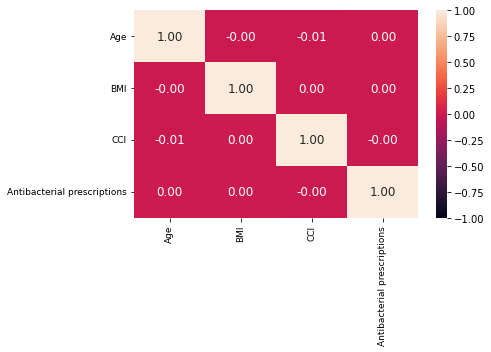

In [71]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti_combined[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti_combined/corr_urti_combined.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [72]:
data_urti_combined = data_urti_combined[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'urti_combined_ab_date', 'ab_type_cat', 'incdt_urti_combined_date', 'date', 'period',
                                   'event_urti_combined_admitted', 'duration_urti_combined_admitted'
                                    ]]

In [73]:
#incident and prevalent infection 
data_urti_combined_incdt = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 0]
data_urti_combined_prevl = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 1]
#switch variable urti_combined_ab_date into a binary variable
data_urti_combined_incdt[['urti_combined_ab_date']] = data_urti_combined_incdt[['urti_combined_ab_date']].where(data_urti_combined_incdt[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)
data_urti_combined_prevl[['urti_combined_ab_date']] = data_urti_combined_prevl[['urti_combined_ab_date']].where(data_urti_combined_prevl[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_urti_combined_incdt_males = data_urti_combined_incdt[data_urti_combined_incdt['sex'] == 'male']
data_urti_combined_incdt_females = data_urti_combined_incdt[data_urti_combined_incdt['sex'] == 'female']
data_urti_combined_prevl_males = data_urti_combined_prevl[data_urti_combined_prevl['sex'] == 'male']
data_urti_combined_prevl_females = data_urti_combined_prevl[data_urti_combined_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_urti_combined_incdt_15_24 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '15_24']
data_urti_combined_incdt_25_34 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '25_34']
data_urti_combined_incdt_35_44 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '35_44']
data_urti_combined_incdt_45_54 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '45_54']
data_urti_combined_incdt_55_64 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '55_64']
data_urti_combined_incdt_65_74 = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '65_74']
data_urti_combined_incdt_75_more = data_urti_combined_incdt[data_urti_combined_incdt['age_cat'] == '75_more']
data_urti_combined_prevl_15_24 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '15_24']
data_urti_combined_prevl_25_34 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '25_34']
data_urti_combined_prevl_35_44 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '35_44']
data_urti_combined_prevl_45_54 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '45_54']
data_urti_combined_prevl_55_64 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '55_64']
data_urti_combined_prevl_65_74 = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '65_74']
data_urti_combined_prevl_75_more = data_urti_combined_prevl[data_urti_combined_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_urti_combined_incdt_prepandemic = data_urti_combined_incdt[data_urti_combined_incdt['date'] <= '2019-12']
data_urti_combined_incdt_during_pandemic = data_urti_combined_incdt[(data_urti_combined_incdt['date'] >= '2020-03') & (data_urti_combined_incdt['date']<= '2021-03')]
data_urti_combined_incdt_post_2nd_lockdown = data_urti_combined_incdt[data_urti_combined_incdt['date'] <= '2021-04']
data_urti_combined_prevl_prepandemic = data_urti_combined_prevl[data_urti_combined_prevl['date'] <= '2019-12']
data_urti_combined_prevl_during_pandemic = data_urti_combined_prevl[(data_urti_combined_prevl['date'] >= '2020-03') & (data_urti_combined_prevl['date']<= '2021-03')]
data_urti_combined_prevl_post_2nd_lockdown = data_urti_combined_prevl[data_urti_combined_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt = data_urti_combined[data_urti_combined['urti_combined_ab_date'].isnull()]
data_urti_combined_no_abs_incdt = data_urti_combined_no_abs_incdt[data_urti_combined_no_abs_incdt['incdt_urti_combined_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_combined_abs_incdt = data_urti_combined[data_urti_combined['urti_combined_ab_date'].notnull()]
data_urti_combined_abs_incdt = data_urti_combined_abs_incdt[data_urti_combined_abs_incdt['incdt_urti_combined_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_combined_no_abs_prevl = data_urti_combined[data_urti_combined['urti_combined_ab_date'].isnull()]
data_urti_combined_no_abs_prevl = data_urti_combined_no_abs_prevl[data_urti_combined_no_abs_prevl['incdt_urti_combined_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_combined_abs_prevl = data_urti_combined[data_urti_combined['urti_combined_ab_date'].notnull()]
data_urti_combined_abs_prevl = data_urti_combined_abs_prevl[data_urti_combined_abs_prevl['incdt_urti_combined_date'] == 1]

In [74]:
#store data for plotting hosp admission counts and percentages
%store data_urti_combined
# save data
data_urti_combined.to_csv('../output/hospitalisation_prediction_urti_combined/data_urti_combined.csv')

Stored 'data_ot_externa' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident urti_combined with no antibiotics

<lifelines.CoxPHFitter: fitted with 112620 total observations, 111801 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 112620
number of events observed = 819
   partial log-likelihood = -9503.29
         time fit was run = 2023-02-02 09:49:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.10            -0.44            -0.05                 0.64                 0.95
CCI_cat[T.medium]               -0.13       0.88       0.11            -0.35             0.08                 0.71                 1.08
CCI_cat[T.high]                 -0.30       0.74       0.14            -0.58            -0.03                 0.56                 0.97
CCI_cat[T.very_high]            -0.10       0.90       0.11            -0.33             0.12                 0.72                 1.13
age_cat[T.25_34]                -0.08       0.93       0.13            -0.33             0.18                 0.72                 1.20
age_cat[T.35_44]                 0.17       1.18       0.12            -0.08             0.41                 0.93                 1.51
age_cat[T.45_54]                -0.16       0.85       0.13            -0.42             0.10                 0.65                 1.11
age_cat[T.55_64]                -0.08       0.92       0.13            -0.34             0.18                 0.71                 1.20
age_cat[T.65_74]                 0.09       1.09       0.13            -0.16             0.34                 0.85                 1.40
age_cat[T.75_more]              -0.20       0.82       0.14            -0.46             0.07                 0.63                 1.07
antibacterial_brit              -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
bmi_cat[T.obese]                 0.04       1.04       0.13            -0.22             0.30                 0.80                 1.35
bmi_cat[T.overweight]           -0.05       0.95       0.16            -0.37             0.27                 0.69                 1.31
bmi_cat[T.underweight]           0.11       1.11       0.22            -0.32             0.54                 0.72                 1.72
bmi_cat[T.unknown]              -0.02       0.98       0.14            -0.30             0.26                 0.74                 1.30
ethnicity[T.unknown]             0.11       1.12       0.11            -0.11             0.34                 0.90                 1.40
ethnicity[T.white]               0.01       1.01       0.10            -0.19             0.21                 0.83                 1.24
flu_vaccine[T.yes]               0.01       1.01       0.12            -0.22             0.24                 0.80                 1.27
imd[T.medium]                   -0.04       0.96       0.11            -0.26             0.18                 0.77                 1.19
imd[T.unaffluent]               -0.10       0.90       0.11            -0.32             0.12                 0.72                 1.13
imd[T.unknown]                  -0.22       0.80       0.19            -0.60             0.15                 0.55                 1.16
imd[T.very_affluent]            -0.08       0.92       0.11            -0.30             0.14                 0.74                 1.15
imd[T.very_unaffluent]           0.02       1.02       0.11            -0.20             0.24                 0.82                 1.27
region[T.east_midlands]         -0.07       0.93       0.15            -0.38             0.23                 0.69                 1.26
region[T.london]                 0.03       1.03     

11986


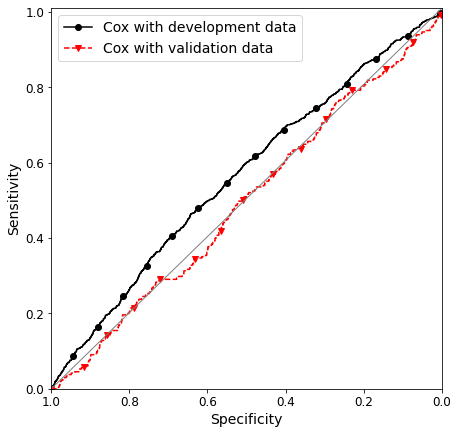

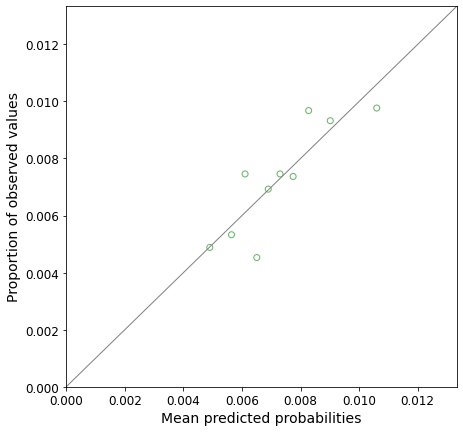

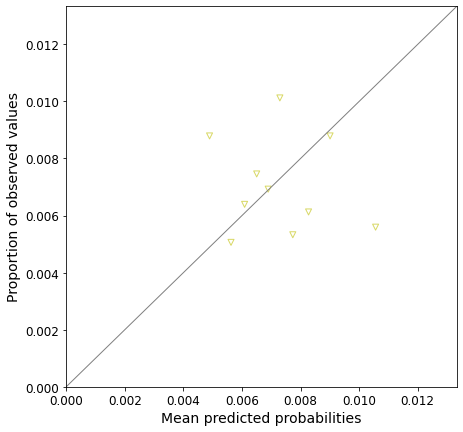

In [75]:
#data prep
data, data_urti_combined_no_abs_incdt_enc = cox_data_prep(data_urti_combined_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt)

try:
    #build cox model 
    cph_urti_combined_no_abs_incdt, data_urti_combined_no_abs_incdt_train, data_urti_combined_no_abs_incdt_test = cox_model_build('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_combined_no_abs_incdt, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_no_abs_incdt.csv', data_urti_combined_no_abs_incdt_enc, data_urti_combined_no_abs_incdt, 'sum_betas_cph_urti_combined_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_combined_no_abs_incdt, 'event_urti_combined_admitted', data_urti_combined_no_abs_incdt_train, data_urti_combined_no_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_combined_no_abs_incdt, data_urti_combined_no_abs_incdt_train, 'event_urti_combined_admitted', data_urti_combined_no_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_no_abs_incdt_train.jpg', 'calibration_cph_urti_combined_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_no_abs_incdt, 'urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt_train, data_urti_combined_no_abs_incdt_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident urti_combined with antibiotics

<lifelines.CoxPHFitter: fitted with 12625 total observations, 12533 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 12625
number of events observed = 92
   partial log-likelihood = -857.65
         time fit was run = 2023-02-02 09:49:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.31            -0.85             0.35                 0.43                 1.43
CCI_cat[T.medium]               -0.04       0.96       0.33            -0.69             0.60                 0.50                 1.83
CCI_cat[T.high]                 -0.28       0.76       0.43            -1.12             0.57                 0.33                 1.76
CCI_cat[T.very_high]             0.11       1.12       0.33            -0.54             0.77                 0.58                 2.15
age_cat[T.25_34]                 0.94       2.56       0.45             0.07             1.82                 1.07                 6.14
age_cat[T.35_44]                 0.53       1.70       0.48            -0.40             1.46                 0.67                 4.32
age_cat[T.45_54]                 0.72       2.06       0.46            -0.17             1.62                 0.84                 5.07
age_cat[T.55_64]                 0.71       2.04       0.46            -0.18             1.61                 0.83                 5.01
age_cat[T.65_74]                 0.51       1.66       0.48            -0.42             1.44                 0.65                 4.23
age_cat[T.75_more]               0.56       1.75       0.47            -0.36             1.48                 0.70                 4.40
antibacterial_brit               0.04       1.04       0.07            -0.10             0.19                 0.91                 1.20
bmi_cat[T.obese]                 0.36       1.44       0.47            -0.56             1.29                 0.57                 3.62
bmi_cat[T.overweight]            0.67       1.95       0.52            -0.36             1.69                 0.70                 5.41
bmi_cat[T.underweight]           0.59       1.80       0.67            -0.73             1.91                 0.48                 6.73
bmi_cat[T.unknown]               0.29       1.34       0.50            -0.68             1.27                 0.50                 3.56
ethnicity[T.unknown]            -0.18       0.84       0.33            -0.82             0.47                 0.44                 1.60
ethnicity[T.white]              -0.16       0.86       0.29            -0.71             0.40                 0.49                 1.50
flu_vaccine[T.yes]              -0.02       0.98       0.35            -0.71             0.67                 0.49                 1.95
imd[T.medium]                   -0.04       0.96       0.36            -0.75             0.67                 0.47                 1.94
imd[T.unaffluent]                0.27       1.31       0.33            -0.38             0.92                 0.68                 2.50
imd[T.unknown]                  -0.05       0.95       0.56            -1.15             1.05                 0.32                 2.85
imd[T.very_affluent]             0.17       1.18       0.34            -0.50             0.83                 0.61                 2.30
imd[T.very_unaffluent]           0.03       1.03       0.35            -0.66             0.71                 0.52                 2.03
region[T.east_midlands]         -0.29       0.75       0.47            -1.20             0.62                 0.30                 1.86
region[T.london]                -0.34       0.71       0.3

11974


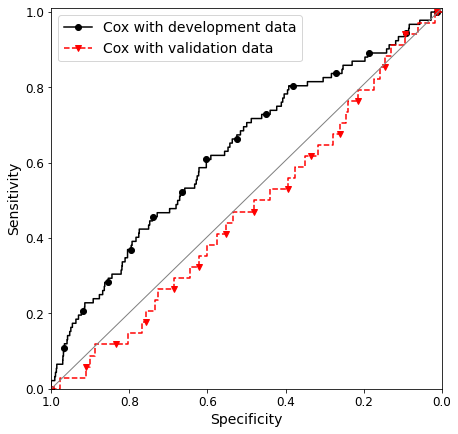

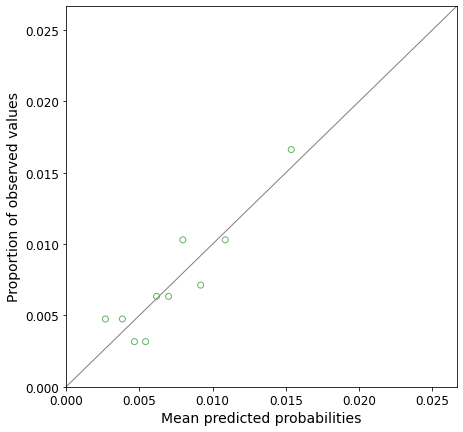

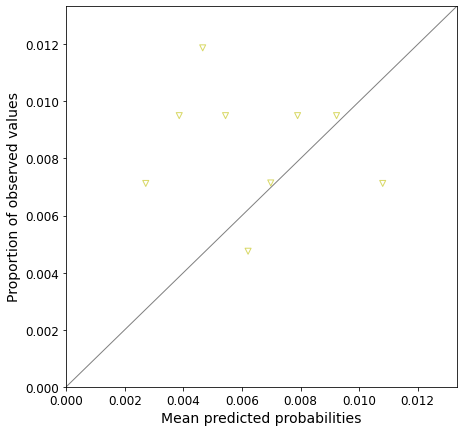

In [76]:
#data prep
data, data_urti_combined_abs_incdt_enc = cox_data_prep(data_urti_combined_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt)

try:
    #build cox model 
    cph_urti_combined_abs_incdt, data_urti_combined_abs_incdt_train, data_urti_combined_abs_incdt_test = cox_model_build('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_combined_abs_incdt, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_abs_incdt.csv', data_urti_combined_abs_incdt_enc, data_urti_combined_abs_incdt, 'sum_betas_cph_urti_combined_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_combined_abs_incdt, 'event_urti_combined_admitted', data_urti_combined_abs_incdt_train, data_urti_combined_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_combined_abs_incdt, data_urti_combined_abs_incdt_train, 'event_urti_combined_admitted', data_urti_combined_abs_incdt_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_abs_incdt_train.jpg', 'calibration_cph_urti_combined_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_abs_incdt, 'urti_combined', 'abs_incdt', data_urti_combined_abs_incdt_train, data_urti_combined_abs_incdt_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent urti_combined with no antibiotics

<lifelines.CoxPHFitter: fitted with 12598 total observations, 12503 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 12598
number of events observed = 95
   partial log-likelihood = -880.46
         time fit was run = 2023-02-02 09:50:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.11       0.31            -0.50             0.71                 0.60                 2.03
CCI_cat[T.medium]                0.09       1.10       0.34            -0.57             0.76                 0.56                 2.13
CCI_cat[T.high]                  0.60       1.82       0.36            -0.11             1.30                 0.90                 3.68
CCI_cat[T.very_high]            -0.60       0.55       0.44            -1.46             0.26                 0.23                 1.29
age_cat[T.25_34]                 0.06       1.07       0.37            -0.65             0.78                 0.52                 2.19
age_cat[T.35_44]                -0.28       0.76       0.40            -1.05             0.50                 0.35                 1.65
age_cat[T.45_54]                 0.31       1.36       0.34            -0.36             0.98                 0.70                 2.66
age_cat[T.55_64]                -0.06       0.94       0.37            -0.79             0.67                 0.46                 1.96
age_cat[T.65_74]                -0.25       0.78       0.40            -1.03             0.52                 0.36                 1.69
age_cat[T.75_more]              -0.50       0.61       0.42            -1.33             0.33                 0.27                 1.39
antibacterial_brit              -0.01       0.99       0.07            -0.16             0.13                 0.86                 1.14
bmi_cat[T.obese]                -0.50       0.61       0.32            -1.14             0.14                 0.32                 1.14
bmi_cat[T.overweight]           -0.39       0.68       0.42            -1.21             0.43                 0.30                 1.54
bmi_cat[T.underweight]          -0.41       0.66       0.65            -1.68             0.85                 0.19                 2.35
bmi_cat[T.unknown]              -0.48       0.62       0.36            -1.18             0.22                 0.31                 1.24
ethnicity[T.unknown]             0.26       1.29       0.33            -0.40             0.91                 0.67                 2.48
ethnicity[T.white]              -0.07       0.93       0.31            -0.68             0.54                 0.51                 1.71
flu_vaccine[T.yes]               0.39       1.48       0.30            -0.20             0.98                 0.82                 2.66
imd[T.medium]                   -0.11       0.90       0.32            -0.74             0.52                 0.48                 1.68
imd[T.unaffluent]               -0.38       0.68       0.35            -1.06             0.30                 0.34                 1.35
imd[T.unknown]                  -0.09       0.92       0.50            -1.07             0.89                 0.34                 2.44
imd[T.very_affluent]            -0.14       0.87       0.33            -0.78             0.49                 0.46                 1.64
imd[T.very_unaffluent]          -0.11       0.89       0.32            -0.74             0.51                 0.48                 1.67
region[T.east_midlands]          0.34       1.40       0.47            -0.57             1.25                 0.56                 3.50
region[T.london]                 0.30       1.35       0.4

11979


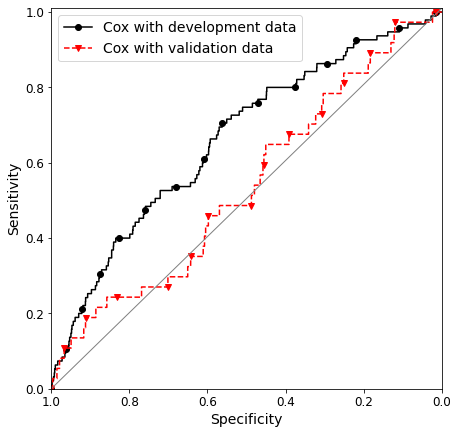

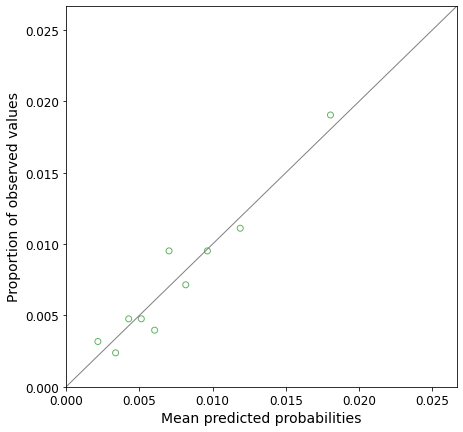

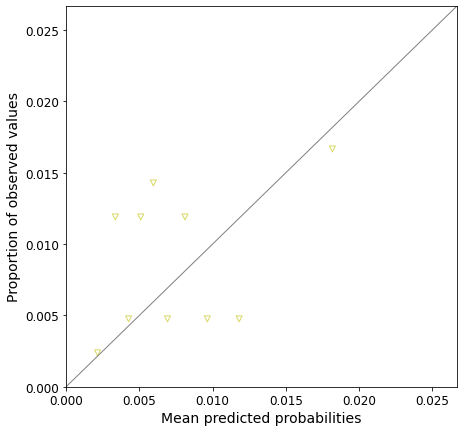

In [77]:
#data prep
data, data_urti_combined_no_abs_prevl_enc = cox_data_prep(data_urti_combined_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl)

try:
    #build cox model 
    cph_urti_combined_no_abs_prevl, data_urti_combined_no_abs_prevl_train, data_urti_combined_no_abs_prevl_test = cox_model_build('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_combined_no_abs_prevl, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_no_abs_prevl.csv', data_urti_combined_no_abs_prevl_enc, data_urti_combined_no_abs_prevl, 'sum_betas_cph_urti_combined_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_combined_no_abs_prevl, 'event_urti_combined_admitted', data_urti_combined_no_abs_prevl_train, data_urti_combined_no_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_combined_no_abs_prevl, data_urti_combined_no_abs_prevl_train, 'event_urti_combined_admitted', data_urti_combined_no_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_no_abs_prevl_train.jpg', 'calibration_cph_urti_combined_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_no_abs_prevl, 'urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl_train, data_urti_combined_no_abs_prevl_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent urti_combined with antibiotics

<lifelines.CoxPHFitter: fitted with 1422 total observations, 1411 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1422
number of events observed = 11
   partial log-likelihood = -64.76
         time fit was run = 2023-02-02 09:50:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.55       1.73       1.17            -1.73             2.83                 0.18                17.00
CCI_cat[T.medium]                0.84       2.32       1.22            -1.56             3.24                 0.21                25.57
CCI_cat[T.high]                  1.08       2.94       1.28            -1.44             3.59                 0.24                36.21
CCI_cat[T.very_high]            -0.29       0.75       1.48            -3.19             2.60                 0.04                13.53
age_cat[T.25_34]                -0.71       0.49       1.29            -3.25             1.82                 0.04                 6.19
age_cat[T.35_44]                -0.88       0.41       1.30            -3.43             1.66                 0.03                 5.28
age_cat[T.45_54]                -1.01       0.36       1.31            -3.58             1.55                 0.03                 4.73
age_cat[T.55_64]                -1.29       0.27       1.38            -4.00             1.41                 0.02                 4.11
age_cat[T.65_74]                 0.23       1.26       0.97            -1.66             2.13                 0.19                 8.38
age_cat[T.75_more]              -0.25       0.78       1.04            -2.29             1.80                 0.10                 6.03
antibacterial_brit              -0.29       0.75       0.26            -0.80             0.23                 0.45                 1.26
bmi_cat[T.obese]                17.27   3.15e+07    7152.67        -14001.72         14036.25                 0.00                  inf
bmi_cat[T.overweight]           19.28   2.35e+08    7152.67        -13999.71         14038.26                 0.00                  inf
bmi_cat[T.underweight]           0.44       1.56   14889.88        -29183.19         29184.08                 0.00                  inf
bmi_cat[T.unknown]              18.12   7.41e+07    7152.67        -14000.86         14037.10                 0.00                  inf
ethnicity[T.unknown]            -0.60       0.55       1.00            -2.56             1.36                 0.08                 3.88
ethnicity[T.white]              -0.52       0.59       0.79            -2.08             1.03                 0.13                 2.80
flu_vaccine[T.yes]               0.35       1.42       0.86            -1.34             2.05                 0.26                 7.74
imd[T.medium]                    0.43       1.54       1.22            -1.97             2.82                 0.14                16.84
imd[T.unaffluent]                0.39       1.47       1.27            -2.11             2.89                 0.12                17.92
imd[T.unknown]                   1.07       2.92       1.47            -1.82             3.96                 0.16                52.49
imd[T.very_affluent]            -0.15       0.86       1.48            -3.05             2.76                 0.05                15.80
imd[T.very_unaffluent]           0.95       2.58       1.19            -1.39             3.29                 0.25                26.73
region[T.east_midlands]         -0.01       0.99       1.36            -2.67             2.64                 0.07                14.06
region[T.london]                 0.13       1.14       1.21   

12102


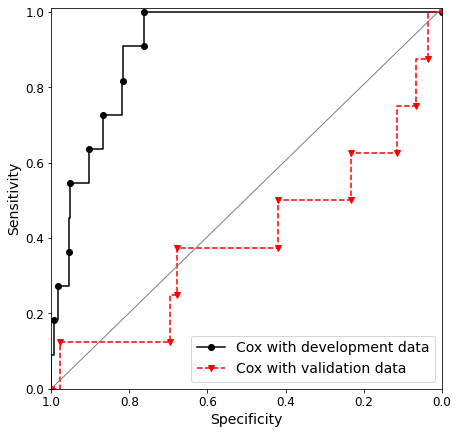

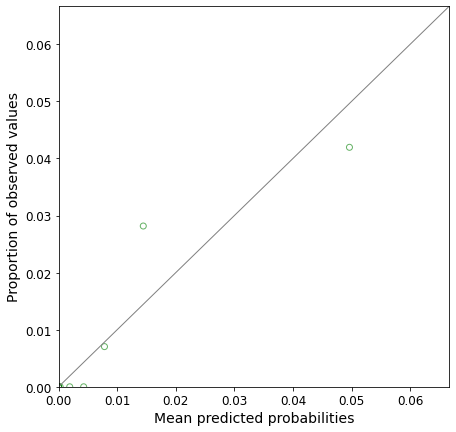

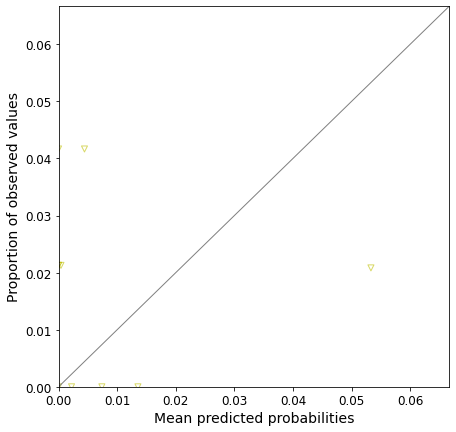

In [78]:
#data prep
data, data_urti_combined_abs_prevl_enc = cox_data_prep(data_urti_combined_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary table
make_summary_table('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl)

try:
    #build cox model 
    cph_urti_combined_abs_prevl, data_urti_combined_abs_prevl_train, data_urti_combined_abs_prevl_test = cox_model_build('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_combined_abs_prevl, '../output/hospitalisation_prediction_urti_combined/', 'betas_cph_urti_combined_abs_prevl.csv', data_urti_combined_abs_prevl_enc, data_urti_combined_abs_prevl, 'sum_betas_cph_urti_combined_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_combined_abs_prevl, 'event_urti_combined_admitted', data_urti_combined_abs_prevl_train, data_urti_combined_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined', 'roc_cph_urti_combined_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_combined_abs_prevl, data_urti_combined_abs_prevl_train, 'event_urti_combined_admitted', data_urti_combined_abs_prevl_test, '../output/hospitalisation_prediction_urti_combined/', 'calibration_cph_urti_combined_abs_prevl_train.jpg', 'calibration_cph_urti_combined_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_abs_prevl, 'urti_combined', 'abs_prevl', data_urti_combined_abs_prevl_train, data_urti_combined_abs_prevl_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident urti_combined

In [79]:
#data prep
data, data_urti_combined_incdt_enc = cox_data_prep(data_urti_combined_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary tables from preped data
make_summary_table('urti_combined', 'incdt', data_urti_combined_incdt_enc)
make_summary_table_hosped('urti_combined', 'incdt', data_urti_combined_incdt)

try:
    cph_urti_combined_incdt, data_urti_combined_incdt_train, data_urti_combined_incdt_test = cox_model_abs_build('urti_combined', 'incdt', data_urti_combined_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt, 'urti_combined', 'incdt', data_urti_combined_incdt_train, data_urti_combined_incdt_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125245 total observations, 124351 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 125245
number of events observed = 894
   partial log-likelihood = -10471.97
         time fit was run = 2023-02-02 09:50:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.10            -0.34             0.04                 0.71                 1.04
CCI_cat[T.medium]               -0.18       0.84       0.11            -0.39             0.04                 0.68                 1.04
CCI_cat[T.high]                 -0.23       0.79       0.13            -0.50             0.03                 0.61                 1.03
CCI_cat[T.very_high]            -0.02       0.98       0.11            -0.23             0.20                 0.79                 1.22
age_cat[T.25_34]                 0.00       1.00       0.13            -0.25             0.25                 0.78                 1.28
age_cat[T.35_44]                 0.18       1.20       0.12            -0.06             0.42                 0.94                 1.52
age_cat[T.45_54]                -0.07       0.93       0.13            -0.32             0.18                 0.72                 1.20
age_cat[T.55_64]                -0.03       0.97       0.13            -0.28             0.22                 0.75                 1.24
age_cat[T.65_74]                 0.15       1.16       0.12            -0.09             0.39                 0.91                 1.47
age_cat[T.75_more]              -0.05       0.96       0.13            -0.30             0.21                 0.74                 1.23
antibacterial_brit               0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
bmi_cat[T.obese]                -0.05       0.95       0.12            -0.30             0.19                 0.74                 1.21
bmi_cat[T.overweight]           -0.12       0.89       0.15            -0.42             0.19                 0.66                 1.20
bmi_cat[T.underweight]          -0.12       0.89       0.22            -0.55             0.32                 0.58                 1.37
bmi_cat[T.unknown]              -0.02       0.98       0.13            -0.28             0.24                 0.75                 1.27
ethnicity[T.unknown]             0.18       1.19       0.11            -0.04             0.39                 0.96                 1.48
ethnicity[T.white]              -0.00       1.00       0.10            -0.20             0.19                 0.82                 1.22
flu_vaccine[T.yes]              -0.01       0.99       0.11            -0.23             0.21                 0.80                 1.24
imd[T.medium]                    0.00       1.00       0.11            -0.21             0.21                 0.81                 1.23
imd[T.unaffluent]               -0.10       0.91       0.11            -0.31             0.11                 0.73                 1.12
imd[T.unknown]                  -0.26       0.77       0.18            -0.62             0.10                 0.54                 1.11
imd[T.very_affluent]            -0.12       0.89       0.11            -0.33             0.10                 0.72                 1.10
imd[T.very_unaffluent]           0.01       1.01       0.11            -0.19             0.22                 0.82                 1.25
ot_externa_ab_date               0.02       1.02       0.11            -0.19             0.24                 0.82                 1.27
region[T.east_midlands]          0.14       1.15    

12238


### 5-6- hospital admission related to prevalent urti_combined

In [80]:
#data prep
data, data_urti_combined_prevl_enc = cox_data_prep(data_urti_combined_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

#make summary tables from preped data
make_summary_table('urti_combined', 'prevl', data_urti_combined_prevl_enc)
make_summary_table_hosped('urti_combined', 'prevl', data_urti_combined_prevl)

try:
    cph_urti_combined_prevl, data_urti_combined_prevl_train, data_urti_combined_prevl_test = cox_model_abs_build('urti_combined', 'prevl', data_urti_combined_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl, 'urti_combined', 'prevl', data_urti_combined_prevl_train, data_urti_combined_prevl_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 14020 total observations, 13894 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 14020
number of events observed = 126
   partial log-likelihood = -1180.64
         time fit was run = 2023-02-02 09:50:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.27            -0.52             0.52                 0.59                 1.68
CCI_cat[T.medium]                0.06       1.07       0.29            -0.49             0.62                 0.61                 1.86
CCI_cat[T.high]                  0.38       1.47       0.32            -0.24             1.01                 0.79                 2.73
CCI_cat[T.very_high]            -0.59       0.55       0.36            -1.30             0.12                 0.27                 1.12
age_cat[T.25_34]                -0.14       0.87       0.37            -0.87             0.59                 0.42                 1.81
age_cat[T.35_44]                 0.11       1.12       0.35            -0.57             0.80                 0.57                 2.22
age_cat[T.45_54]                 0.40       1.50       0.32            -0.23             1.04                 0.79                 2.82
age_cat[T.55_64]                 0.31       1.37       0.33            -0.33             0.96                 0.72                 2.61
age_cat[T.65_74]                 0.26       1.30       0.34            -0.39             0.92                 0.67                 2.52
age_cat[T.75_more]              -0.11       0.90       0.37            -0.82             0.61                 0.44                 1.85
antibacterial_brit              -0.06       0.94       0.06            -0.19             0.07                 0.83                 1.07
bmi_cat[T.obese]                -0.49       0.61       0.29            -1.06             0.08                 0.35                 1.09
bmi_cat[T.overweight]            0.07       1.07       0.34            -0.59             0.74                 0.55                 2.09
bmi_cat[T.underweight]          -0.13       0.87       0.52            -1.15             0.88                 0.32                 2.41
bmi_cat[T.unknown]              -0.47       0.63       0.32            -1.10             0.16                 0.33                 1.17
ethnicity[T.unknown]            -0.16       0.85       0.26            -0.68             0.35                 0.51                 1.43
ethnicity[T.white]              -0.44       0.64       0.24            -0.91             0.02                 0.40                 1.02
flu_vaccine[T.yes]               0.34       1.41       0.26            -0.17             0.86                 0.84                 2.35
imd[T.medium]                    0.03       1.03       0.28            -0.52             0.57                 0.59                 1.77
imd[T.unaffluent]               -0.28       0.76       0.30            -0.87             0.31                 0.42                 1.37
imd[T.unknown]                   0.12       1.12       0.41            -0.68             0.91                 0.51                 2.49
imd[T.very_affluent]            -0.16       0.85       0.29            -0.74             0.41                 0.48                 1.51
imd[T.very_unaffluent]          -0.10       0.90       0.29            -0.66             0.46                 0.51                 1.58
ot_externa_ab_date               0.17       1.18       0.28            -0.37             0.71                 0.69                 2.03
region[T.east_midlands]          0.28       1.32       0

12229


### 5-7- hospital admission related to incident urti_combined with prescribed antibiotics categories

In [81]:
#data prep
data, data_urti_combined_incdt_abs_enc = cox_data_prep(data_urti_combined_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_abs, data_urti_combined_incdt_abs_train, data_urti_combined_incdt_abs_test = cox_model_ab_type_build('urti_combined', 'incdt_ab_type', data_urti_combined_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_abs, 'urti_combined', 'incdt_abs', data_urti_combined_incdt_abs_train, data_urti_combined_incdt_abs_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125245 total observations, 124351 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 125245
number of events observed = 894
   partial log-likelihood = -10470.14
         time fit was run = 2023-02-02 09:50:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.10            -0.34             0.04                 0.71                 1.04
CCI_cat[T.medium]               -0.18       0.84       0.11            -0.39             0.04                 0.68                 1.04
CCI_cat[T.high]                 -0.23       0.79       0.13            -0.50             0.03                 0.61                 1.03
CCI_cat[T.very_high]            -0.02       0.98       0.11            -0.23             0.20                 0.79                 1.22
ab_type_cat[T.Doxycycline]     -12.71       0.00     454.10          -902.73           877.30                 0.00                  inf
ab_type_cat[T.no]                0.08       1.08       0.45            -0.80             0.95                 0.45                 2.60
ab_type_cat[T.other]             0.13       1.13       0.46            -0.78             1.03                 0.46                 2.79
age_cat[T.25_34]                 0.00       1.00       0.13            -0.25             0.25                 0.78                 1.28
age_cat[T.35_44]                 0.18       1.20       0.12            -0.06             0.42                 0.94                 1.52
age_cat[T.45_54]                -0.07       0.93       0.13            -0.32             0.18                 0.72                 1.20
age_cat[T.55_64]                -0.03       0.97       0.13            -0.28             0.22                 0.75                 1.24
age_cat[T.65_74]                 0.15       1.16       0.12            -0.09             0.39                 0.91                 1.47
age_cat[T.75_more]              -0.05       0.96       0.13            -0.30             0.21                 0.74                 1.23
antibacterial_brit               0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
bmi_cat[T.obese]                -0.05       0.95       0.12            -0.30             0.19                 0.74                 1.21
bmi_cat[T.overweight]           -0.12       0.89       0.15            -0.42             0.19                 0.66                 1.20
bmi_cat[T.underweight]          -0.11       0.89       0.22            -0.55             0.32                 0.58                 1.38
bmi_cat[T.unknown]              -0.02       0.98       0.13            -0.28             0.24                 0.76                 1.27
ethnicity[T.unknown]             0.18       1.19       0.11            -0.04             0.39                 0.96                 1.48
ethnicity[T.white]              -0.00       1.00       0.10            -0.19             0.19                 0.82                 1.22
flu_vaccine[T.yes]              -0.01       0.99       0.11            -0.23             0.21                 0.80                 1.24
imd[T.medium]                    0.00       1.00       0.11            -0.21             0.21                 0.81                 1.23
imd[T.unaffluent]               -0.10       0.91       0.11            -0.31             0.11                 0.73                 1.12
imd[T.unknown]                  -0.26       0.77       0.18            -0.62             0.10                 0.54                 1.11
imd[T.very_affluent]            -0.12       0.89    

12763


### 5-8- hospital admission related to prevalent urti_combined with prescribed antibiotics categories

In [82]:
#data prep
data, data_urti_combined_prevl_abs_enc = cox_data_prep(data_urti_combined_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_abs, data_urti_combined_prevl_abs_train, data_urti_combined_prevl_abs_test = cox_model_ab_type_build('urti_combined', 'prevl_ab_type', data_urti_combined_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_abs, 'urti_combined', 'prevl_abs', data_urti_combined_prevl_abs_train, data_urti_combined_prevl_abs_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 14020 total observations, 13894 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 14020
number of events observed = 126
   partial log-likelihood = -1179.41
         time fit was run = 2023-02-02 09:50:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.27            -0.52             0.52                 0.59                 1.68
CCI_cat[T.medium]                0.07       1.07       0.29            -0.49             0.63                 0.61                 1.87
CCI_cat[T.high]                  0.38       1.46       0.32            -0.25             1.00                 0.78                 2.71
CCI_cat[T.very_high]            -0.60       0.55       0.36            -1.31             0.11                 0.27                 1.12
ab_type_cat[T.Doxycycline]       0.63       1.87       1.23            -1.78             3.04                 0.17                20.85
ab_type_cat[T.no]               -0.94       0.39       0.72            -2.35             0.47                 0.10                 1.60
ab_type_cat[T.other]            -0.91       0.40       0.77            -2.42             0.59                 0.09                 1.81
age_cat[T.25_34]                -0.15       0.86       0.37            -0.88             0.59                 0.42                 1.80
age_cat[T.35_44]                 0.10       1.11       0.35            -0.58             0.79                 0.56                 2.20
age_cat[T.45_54]                 0.40       1.49       0.32            -0.23             1.03                 0.79                 2.81
age_cat[T.55_64]                 0.31       1.36       0.33            -0.34             0.95                 0.71                 2.59
age_cat[T.65_74]                 0.26       1.30       0.34            -0.40             0.92                 0.67                 2.51
age_cat[T.75_more]              -0.11       0.90       0.37            -0.83             0.61                 0.44                 1.84
antibacterial_brit              -0.06       0.94       0.06            -0.19             0.07                 0.83                 1.07
bmi_cat[T.obese]                -0.50       0.60       0.29            -1.07             0.07                 0.34                 1.07
bmi_cat[T.overweight]            0.07       1.07       0.34            -0.60             0.73                 0.55                 2.08
bmi_cat[T.underweight]          -0.13       0.88       0.52            -1.15             0.88                 0.32                 2.42
bmi_cat[T.unknown]              -0.48       0.62       0.32            -1.10             0.15                 0.33                 1.17
ethnicity[T.unknown]            -0.16       0.85       0.26            -0.68             0.35                 0.51                 1.42
ethnicity[T.white]              -0.44       0.64       0.24            -0.91             0.03                 0.40                 1.03
flu_vaccine[T.yes]               0.33       1.38       0.26            -0.19             0.84                 0.83                 2.31
imd[T.medium]                    0.04       1.04       0.28            -0.51             0.58                 0.60                 1.79
imd[T.unaffluent]               -0.28       0.76       0.30            -0.87             0.31                 0.42                 1.36
imd[T.unknown]                   0.12       1.12       0.41            -0.68             0.92                 0.51                 2.50
imd[T.very_affluent]            -0.15       0.86       0

12751


### 5-9- stratified by sex
#### 5-9-1- incident males

In [83]:
#data prep
data, data_urti_combined_incdt_males_enc = cox_data_prep(data_urti_combined_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_males, data_urti_combined_incdt_males_train, data_urti_combined_incdt_males_test = cox_model_strat_sex_build('urti_combined', 'incdt_males', data_urti_combined_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_males, 'urti_combined', 'incdt_males', data_urti_combined_incdt_males_train, data_urti_combined_incdt_males_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61306 total observations, 60856 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 61306
number of events observed = 450
   partial log-likelihood = -4940.76
         time fit was run = 2023-02-02 09:50:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.13            -0.41             0.11                 0.67                 1.11
CCI_cat[T.medium]               -0.41       0.67       0.16            -0.71            -0.10                 0.49                 0.90
CCI_cat[T.high]                 -0.19       0.83       0.18            -0.54             0.17                 0.58                 1.18
CCI_cat[T.very_high]            -0.20       0.82       0.16            -0.50             0.11                 0.60                 1.12
age_cat[T.25_34]                 0.02       1.02       0.18            -0.34             0.37                 0.71                 1.45
age_cat[T.35_44]                 0.21       1.23       0.17            -0.14             0.55                 0.87                 1.73
age_cat[T.45_54]                 0.01       1.01       0.18            -0.35             0.36                 0.70                 1.44
age_cat[T.55_64]                -0.03       0.97       0.18            -0.39             0.33                 0.68                 1.38
age_cat[T.65_74]                 0.10       1.11       0.18            -0.24             0.45                 0.78                 1.57
age_cat[T.75_more]               0.16       1.17       0.18            -0.19             0.50                 0.83                 1.65
antibacterial_brit               0.01       1.01       0.03            -0.05             0.08                 0.95                 1.08
bmi_cat[T.obese]                -0.01       0.99       0.18            -0.36             0.33                 0.70                 1.40
bmi_cat[T.overweight]           -0.07       0.93       0.22            -0.50             0.36                 0.61                 1.44
bmi_cat[T.underweight]          -0.29       0.75       0.33            -0.94             0.36                 0.39                 1.44
bmi_cat[T.unknown]              -0.05       0.95       0.19            -0.42             0.33                 0.66                 1.38
ethnicity[T.unknown]             0.28       1.32       0.16            -0.03             0.58                 0.97                 1.79
ethnicity[T.white]               0.05       1.05       0.14            -0.23             0.33                 0.80                 1.40
flu_vaccine[T.yes]               0.12       1.12       0.15            -0.18             0.41                 0.83                 1.51
imd[T.medium]                   -0.24       0.78       0.16            -0.56             0.07                 0.57                 1.07
imd[T.unaffluent]               -0.16       0.85       0.16            -0.47             0.15                 0.63                 1.16
imd[T.unknown]                  -0.12       0.89       0.25            -0.60             0.37                 0.55                 1.45
imd[T.very_affluent]             0.09       1.09       0.15            -0.20             0.38                 0.82                 1.46
imd[T.very_unaffluent]           0.17       1.19       0.14            -0.11             0.45                 0.89                 1.57
ot_externa_ab_date              -0.05       0.95       0.16            -0.37             0.26                 0.69                 1.30
region[T.east_midlands]          0.23       1.25       0

11971


#### 5-9-2- incident females

In [84]:
#data prep
data, data_urti_combined_incdt_females_enc = cox_data_prep(data_urti_combined_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_females, data_urti_combined_incdt_females_train, data_urti_combined_incdt_females_test = cox_model_strat_sex_build('urti_combined', 'incdt_females', data_urti_combined_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_females, 'urti_combined', 'incdt_females', data_urti_combined_incdt_females_train, data_urti_combined_incdt_females_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 63939 total observations, 63467 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 63939
number of events observed = 472
   partial log-likelihood = -5195.69
         time fit was run = 2023-02-02 09:50:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.21       0.81       0.14            -0.49             0.06                 0.61                 1.06
CCI_cat[T.medium]                0.05       1.05       0.15            -0.24             0.33                 0.79                 1.39
CCI_cat[T.high]                 -0.12       0.89       0.19            -0.49             0.24                 0.62                 1.27
CCI_cat[T.very_high]             0.18       1.19       0.15            -0.12             0.47                 0.89                 1.60
age_cat[T.25_34]                -0.14       0.87       0.17            -0.48             0.20                 0.62                 1.22
age_cat[T.35_44]                -0.01       0.99       0.17            -0.33             0.32                 0.72                 1.38
age_cat[T.45_54]                -0.09       0.92       0.17            -0.42             0.24                 0.66                 1.27
age_cat[T.55_64]                -0.10       0.90       0.17            -0.44             0.23                 0.65                 1.26
age_cat[T.65_74]                 0.11       1.12       0.16            -0.21             0.43                 0.81                 1.53
age_cat[T.75_more]              -0.28       0.75       0.18            -0.64             0.07                 0.53                 1.07
antibacterial_brit              -0.01       0.99       0.03            -0.07             0.06                 0.93                 1.06
bmi_cat[T.obese]                 0.00       1.00       0.18            -0.34             0.35                 0.71                 1.42
bmi_cat[T.overweight]            0.08       1.08       0.21            -0.34             0.49                 0.71                 1.63
bmi_cat[T.underweight]           0.37       1.44       0.27            -0.17             0.90                 0.84                 2.47
bmi_cat[T.unknown]               0.04       1.04       0.19            -0.33             0.41                 0.72                 1.51
ethnicity[T.unknown]            -0.16       0.85       0.15            -0.45             0.12                 0.64                 1.13
ethnicity[T.white]              -0.18       0.84       0.13            -0.43             0.07                 0.65                 1.07
flu_vaccine[T.yes]              -0.23       0.79       0.17            -0.56             0.10                 0.57                 1.11
imd[T.medium]                    0.02       1.02       0.14            -0.26             0.30                 0.77                 1.35
imd[T.unaffluent]               -0.13       0.87       0.15            -0.42             0.15                 0.66                 1.17
imd[T.unknown]                  -0.22       0.80       0.25            -0.70             0.26                 0.50                 1.30
imd[T.very_affluent]            -0.17       0.84       0.15            -0.46             0.12                 0.63                 1.13
imd[T.very_unaffluent]          -0.18       0.84       0.15            -0.47             0.12                 0.62                 1.12
ot_externa_ab_date               0.10       1.11       0.15            -0.19             0.39                 0.83                 1.48
region[T.east_midlands]          0.11       1.12       0

11989


#### 5-9-3- prevalent males

In [85]:
#data prep
data, data_urti_combined_prevl_males_enc = cox_data_prep(data_urti_combined_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_males, data_urti_combined_prevl_males_train, data_urti_combined_prevl_males_test = cox_model_strat_sex_build('urti_combined', 'prevl_males', data_urti_combined_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_males, 'urti_combined', 'prevl_males', data_urti_combined_prevl_males_train, data_urti_combined_prevl_males_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6871 total observations, 6820 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 6871
number of events observed = 51
   partial log-likelihood = -416.09
         time fit was run = 2023-02-02 09:50:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.63       0.53       0.43            -1.47             0.21                 0.23                 1.24
CCI_cat[T.medium]               -0.40       0.67       0.46            -1.30             0.50                 0.27                 1.66
CCI_cat[T.high]                  0.85       2.33       0.41             0.03             1.66                 1.03                 5.25
CCI_cat[T.very_high]            -0.65       0.52       0.55            -1.73             0.43                 0.18                 1.53
age_cat[T.25_34]                 0.98       2.68       0.54            -0.08             2.05                 0.92                 7.75
age_cat[T.35_44]                -0.62       0.54       0.84            -2.27             1.03                 0.10                 2.79
age_cat[T.45_54]                 1.13       3.08       0.53             0.08             2.17                 1.09                 8.74
age_cat[T.55_64]                 0.50       1.65       0.57            -0.62             1.62                 0.54                 5.07
age_cat[T.65_74]                 0.72       2.05       0.56            -0.38             1.82                 0.68                 6.15
age_cat[T.75_more]              -0.36       0.70       0.73            -1.80             1.07                 0.17                 2.93
antibacterial_brit              -0.01       0.99       0.10            -0.21             0.18                 0.81                 1.20
bmi_cat[T.obese]                -1.13       0.32       0.41            -1.93            -0.33                 0.14                 0.72
bmi_cat[T.overweight]           -0.35       0.70       0.49            -1.32             0.61                 0.27                 1.84
bmi_cat[T.underweight]          -0.71       0.49       0.78            -2.25             0.83                 0.11                 2.28
bmi_cat[T.unknown]              -0.73       0.48       0.44            -1.59             0.12                 0.20                 1.13
ethnicity[T.unknown]            -0.63       0.53       0.39            -1.40             0.13                 0.25                 1.14
ethnicity[T.white]              -0.94       0.39       0.34            -1.60            -0.27                 0.20                 0.76
flu_vaccine[T.yes]               0.87       2.38       0.36             0.17             1.57                 1.18                 4.80
imd[T.medium]                    0.01       1.01       0.40            -0.78             0.80                 0.46                 2.22
imd[T.unaffluent]               -0.48       0.62       0.46            -1.38             0.42                 0.25                 1.53
imd[T.unknown]                  -0.02       0.98       0.58            -1.16             1.13                 0.31                 3.09
imd[T.very_affluent]            -0.52       0.59       0.46            -1.42             0.38                 0.24                 1.46
imd[T.very_unaffluent]          -0.81       0.45       0.50            -1.79             0.18                 0.17                 1.20
ot_externa_ab_date              -0.23       0.79       0.52            -1.26             0.79                 0.28                 2.21
region[T.east_midlands]          0.35       1.43       0.59  

12026


#### 5-9-4- prevalent females

In [86]:
try:
    #data prep
    data, data_urti_combined_prevl_females_enc = cox_data_prep(data_urti_combined_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

    #cox model
    cph_urti_combined_prevl_females, data_urti_combined_prevl_females_train, data_urti_combined_prevl_females_test = cox_model_strat_sex_build('urti_combined', 'prevl_females', data_urti_combined_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_females, 'urti_combined', 'prevl_females', data_urti_combined_prevl_females_train, data_urti_combined_prevl_females_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7149 total observations, 7085 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 7149
number of events observed = 64
   partial log-likelihood = -546.56
         time fit was run = 2023-02-02 09:50:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.54       1.71       0.43            -0.30             1.37                 0.74                 3.94
CCI_cat[T.medium]                0.54       1.72       0.45            -0.35             1.43                 0.71                 4.19
CCI_cat[T.high]                  0.33       1.39       0.56            -0.77             1.42                 0.46                 4.14
CCI_cat[T.very_high]             0.11       1.12       0.51            -0.88             1.11                 0.42                 3.02
age_cat[T.25_34]                -0.47       0.62       0.53            -1.51             0.56                 0.22                 1.76
age_cat[T.35_44]                -0.15       0.86       0.49            -1.11             0.80                 0.33                 2.23
age_cat[T.45_54]                 0.43       1.53       0.43            -0.41             1.27                 0.66                 3.55
age_cat[T.55_64]                -0.18       0.83       0.49            -1.14             0.77                 0.32                 2.16
age_cat[T.65_74]                -0.10       0.91       0.47            -1.02             0.83                 0.36                 2.30
age_cat[T.75_more]              -0.02       0.98       0.46            -0.92             0.89                 0.40                 2.43
antibacterial_brit              -0.11       0.90       0.09            -0.29             0.07                 0.75                 1.08
bmi_cat[T.obese]                 0.28       1.32       0.48            -0.66             1.22                 0.52                 3.38
bmi_cat[T.overweight]            0.54       1.71       0.55            -0.54             1.62                 0.58                 5.03
bmi_cat[T.underweight]           0.21       1.24       0.84            -1.43             1.86                 0.24                 6.42
bmi_cat[T.unknown]              -0.25       0.78       0.54            -1.31             0.81                 0.27                 2.25
ethnicity[T.unknown]            -0.09       0.91       0.41            -0.89             0.70                 0.41                 2.02
ethnicity[T.white]              -0.08       0.93       0.36            -0.78             0.63                 0.46                 1.87
flu_vaccine[T.yes]               0.04       1.04       0.40            -0.75             0.83                 0.47                 2.28
imd[T.medium]                   -0.20       0.82       0.37            -0.92             0.52                 0.40                 1.68
imd[T.unaffluent]               -0.77       0.46       0.43            -1.62             0.08                 0.20                 1.09
imd[T.unknown]                  -0.20       0.81       0.56            -1.30             0.89                 0.27                 2.44
imd[T.very_affluent]            -0.69       0.50       0.42            -1.51             0.13                 0.22                 1.14
imd[T.very_unaffluent]          -0.29       0.75       0.38            -1.03             0.44                 0.36                 1.56
ot_externa_ab_date               0.25       1.28       0.38            -0.50             0.99                 0.61                 2.70
region[T.east_midlands]          0.00       1.00       0.71  

11977


### 5-10- stratified by age category
#### 5-10-1- incident

In [87]:
#data prep
data, data_urti_combined_incdt_15_24_enc = cox_data_prep(data_urti_combined_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_15_24, data_urti_combined_incdt_15_24_train, data_urti_combined_incdt_15_24_test = cox_model_strat_age_build('urti_combined', 'incdt_15_24', data_urti_combined_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_15_24, 'urti_combined', 'incdt_15_24', data_urti_combined_incdt_15_24_train, data_urti_combined_incdt_15_24_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17966 total observations, 17825 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17966
number of events observed = 141
   partial log-likelihood = -1365.33
         time fit was run = 2023-02-02 09:50:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.11       0.25            -0.38             0.59                 0.68                 1.80
CCI_cat[T.medium]               -0.05       0.95       0.28            -0.60             0.49                 0.55                 1.64
CCI_cat[T.high]                 -0.24       0.78       0.36            -0.96             0.47                 0.38                 1.60
CCI_cat[T.very_high]             0.07       1.08       0.29            -0.49             0.63                 0.61                 1.89
antibacterial_brit              -0.08       0.92       0.06            -0.20             0.04                 0.82                 1.04
bmi_cat[T.obese]                -0.21       0.81       0.30            -0.80             0.39                 0.45                 1.47
bmi_cat[T.overweight]           -0.03       0.97       0.37            -0.76             0.69                 0.47                 2.00
bmi_cat[T.underweight]           0.35       1.42       0.47            -0.57             1.27                 0.57                 3.57
bmi_cat[T.unknown]              -0.06       0.94       0.32            -0.69             0.57                 0.50                 1.77
ethnicity[T.unknown]             0.40       1.49       0.34            -0.27             1.07                 0.77                 2.90
ethnicity[T.white]               0.68       1.98       0.31             0.08             1.28                 1.08                 3.60
flu_vaccine[T.yes]              -0.07       0.93       0.30            -0.66             0.52                 0.51                 1.69
imd[T.medium]                   -0.04       0.96       0.26            -0.55             0.46                 0.58                 1.59
imd[T.unaffluent]               -0.63       0.53       0.31            -1.23            -0.02                 0.29                 0.98
imd[T.unknown]                  -0.06       0.94       0.42            -0.89             0.76                 0.41                 2.15
imd[T.very_affluent]            -0.07       0.93       0.26            -0.59             0.45                 0.56                 1.56
imd[T.very_unaffluent]           0.04       1.04       0.26            -0.46             0.55                 0.63                 1.73
ot_externa_ab_date              -0.47       0.63       0.34            -1.14             0.21                 0.32                 1.23
region[T.east_midlands]          0.08       1.08       0.37            -0.64             0.80                 0.53                 2.22
region[T.london]                -0.11       0.90       0.33            -0.76             0.54                 0.47                 1.72
region[T.north_east]            -0.47       0.63       0.43            -1.31             0.37                 0.27                 1.45
region[T.north_west]             0.29       1.34       0.35            -0.40             0.98                 0.67                 2.67
region[T.south_east]             0.32       1.38       0.35            -0.36             1.01                 0.70                 2.74
region[T.south_west]            -0.08       0.92       0.39            -0.84             0.67                 0.43                 1.96
region[T.west_midlands]         -0.47       0.62       0

10723


In [88]:
#data prep
data, data_urti_combined_incdt_25_34_enc = cox_data_prep(data_urti_combined_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_25_34, data_urti_combined_incdt_25_34_train, data_urti_combined_incdt_25_34_test = cox_model_strat_age_build('urti_combined', 'incdt_25_34', data_urti_combined_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_25_34, 'urti_combined', 'incdt_25_34', data_urti_combined_incdt_25_34_train, data_urti_combined_incdt_25_34_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18029 total observations, 17901 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 18029
number of events observed = 128
   partial log-likelihood = -1239.27
         time fit was run = 2023-02-02 09:50:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.78       0.27            -0.76             0.28                 0.47                 1.32
CCI_cat[T.medium]                0.05       1.05       0.28            -0.49             0.59                 0.61                 1.80
CCI_cat[T.high]                 -0.26       0.77       0.37            -0.98             0.46                 0.38                 1.59
CCI_cat[T.very_high]             0.15       1.16       0.29            -0.41             0.71                 0.66                 2.03
antibacterial_brit               0.03       1.03       0.06            -0.09             0.15                 0.91                 1.16
bmi_cat[T.obese]                 0.16       1.17       0.35            -0.54             0.85                 0.58                 2.35
bmi_cat[T.overweight]           -0.24       0.79       0.46            -1.14             0.66                 0.32                 1.94
bmi_cat[T.underweight]           0.27       1.31       0.56            -0.82             1.37                 0.44                 3.92
bmi_cat[T.unknown]               0.24       1.27       0.37            -0.49             0.98                 0.61                 2.65
ethnicity[T.unknown]            -0.04       0.96       0.30            -0.62             0.55                 0.54                 1.73
ethnicity[T.white]               0.08       1.08       0.26            -0.44             0.59                 0.65                 1.80
flu_vaccine[T.yes]              -1.01       0.37       0.46            -1.90            -0.11                 0.15                 0.89
imd[T.medium]                    0.27       1.30       0.29            -0.30             0.83                 0.74                 2.30
imd[T.unaffluent]                0.25       1.29       0.29            -0.31             0.82                 0.73                 2.27
imd[T.unknown]                  -0.11       0.90       0.50            -1.09             0.87                 0.34                 2.38
imd[T.very_affluent]             0.14       1.15       0.30            -0.45             0.72                 0.64                 2.06
imd[T.very_unaffluent]           0.05       1.06       0.31            -0.54             0.65                 0.58                 1.92
ot_externa_ab_date               0.40       1.50       0.25            -0.09             0.90                 0.91                 2.47
region[T.east_midlands]         -0.05       0.95       0.35            -0.74             0.63                 0.48                 1.88
region[T.london]                -0.20       0.82       0.31            -0.81             0.40                 0.45                 1.49
region[T.north_east]            -0.37       0.69       0.38            -1.11             0.37                 0.33                 1.44
region[T.north_west]            -0.79       0.45       0.43            -1.64             0.05                 0.19                 1.05
region[T.south_east]            -0.43       0.65       0.38            -1.17             0.31                 0.31                 1.36
region[T.south_west]            -0.23       0.79       0.37            -0.95             0.49                 0.39                 1.63
region[T.west_midlands]         -0.19       0.83       0

10710


In [89]:
#data prep
data, data_urti_combined_incdt_35_44_enc = cox_data_prep(data_urti_combined_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_35_44, data_urti_combined_incdt_35_44_train, data_urti_combined_incdt_35_44_test = cox_model_strat_age_build('urti_combined', 'incdt_35_44', data_urti_combined_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_35_44, 'urti_combined', 'incdt_35_44', data_urti_combined_incdt_35_44_train, data_urti_combined_incdt_35_44_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17695 total observations, 17566 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17695
number of events observed = 129
   partial log-likelihood = -1245.17
         time fit was run = 2023-02-02 09:50:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.23            -0.71             0.19                 0.49                 1.21
CCI_cat[T.medium]               -0.39       0.68       0.27            -0.92             0.14                 0.40                 1.15
CCI_cat[T.high]                 -0.81       0.45       0.40            -1.58            -0.03                 0.20                 0.97
CCI_cat[T.very_high]            -0.54       0.58       0.30            -1.13             0.05                 0.32                 1.05
antibacterial_brit               0.04       1.04       0.06            -0.08             0.16                 0.92                 1.17
bmi_cat[T.obese]                -0.04       0.96       0.32            -0.67             0.60                 0.51                 1.82
bmi_cat[T.overweight]           -0.06       0.94       0.40            -0.84             0.72                 0.43                 2.05
bmi_cat[T.underweight]          -0.91       0.40       0.77            -2.42             0.60                 0.09                 1.82
bmi_cat[T.unknown]              -0.25       0.78       0.35            -0.94             0.45                 0.39                 1.56
ethnicity[T.unknown]             0.07       1.08       0.29            -0.49             0.63                 0.61                 1.89
ethnicity[T.white]               0.01       1.01       0.26            -0.50             0.51                 0.61                 1.66
flu_vaccine[T.yes]               0.07       1.07       0.28            -0.49             0.62                 0.61                 1.87
imd[T.medium]                   -0.40       0.67       0.31            -1.02             0.21                 0.36                 1.23
imd[T.unaffluent]               -0.19       0.82       0.29            -0.77             0.38                 0.46                 1.46
imd[T.unknown]                  -0.21       0.81       0.49            -1.17             0.74                 0.31                 2.10
imd[T.very_affluent]            -0.05       0.95       0.28            -0.60             0.51                 0.55                 1.66
imd[T.very_unaffluent]           0.34       1.40       0.26            -0.17             0.84                 0.84                 2.32
ot_externa_ab_date              -0.16       0.85       0.32            -0.78             0.46                 0.46                 1.58
region[T.east_midlands]         -0.50       0.60       0.38            -1.25             0.25                 0.29                 1.28
region[T.london]                -0.31       0.74       0.30            -0.90             0.29                 0.41                 1.33
region[T.north_east]            -0.38       0.68       0.36            -1.10             0.33                 0.33                 1.40
region[T.north_west]            -0.72       0.49       0.41            -1.52             0.08                 0.22                 1.09
region[T.south_east]            -0.18       0.84       0.34            -0.85             0.49                 0.43                 1.64
region[T.south_west]            -0.96       0.38       0.45            -1.84            -0.09                 0.16                 0.91
region[T.west_midlands]         -0.19       0.82       0

10725


In [90]:
#data prep
data, data_urti_combined_incdt_45_54_enc = cox_data_prep(data_urti_combined_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_45_54, data_urti_combined_incdt_45_54_train, data_urti_combined_incdt_45_54_test = cox_model_strat_age_build('urti_combined', 'incdt_45_54', data_urti_combined_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_45_54, 'urti_combined', 'incdt_45_54', data_urti_combined_incdt_45_54_train, data_urti_combined_incdt_45_54_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17906 total observations, 17783 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17906
number of events observed = 123
   partial log-likelihood = -1179.25
         time fit was run = 2023-02-02 09:50:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.26            -0.85             0.16                 0.43                 1.17
CCI_cat[T.medium]               -0.24       0.79       0.28            -0.79             0.32                 0.45                 1.38
CCI_cat[T.high]                 -0.44       0.64       0.37            -1.18             0.29                 0.31                 1.34
CCI_cat[T.very_high]            -0.06       0.94       0.28            -0.61             0.50                 0.54                 1.64
antibacterial_brit               0.02       1.02       0.06            -0.11             0.14                 0.90                 1.15
bmi_cat[T.obese]                -0.28       0.76       0.32            -0.90             0.34                 0.41                 1.41
bmi_cat[T.overweight]           -0.01       0.99       0.38            -0.76             0.74                 0.47                 2.09
bmi_cat[T.underweight]          -0.50       0.60       0.65            -1.77             0.76                 0.17                 2.15
bmi_cat[T.unknown]              -0.13       0.88       0.34            -0.79             0.54                 0.45                 1.71
ethnicity[T.unknown]            -0.21       0.81       0.30            -0.80             0.38                 0.45                 1.47
ethnicity[T.white]               0.03       1.03       0.26            -0.47             0.53                 0.62                 1.70
flu_vaccine[T.yes]               0.32       1.37       0.27            -0.21             0.84                 0.81                 2.33
imd[T.medium]                    0.31       1.37       0.27            -0.21             0.84                 0.81                 2.31
imd[T.unaffluent]               -0.62       0.54       0.34            -1.28             0.04                 0.28                 1.04
imd[T.unknown]                  -0.48       0.62       0.54            -1.54             0.58                 0.21                 1.79
imd[T.very_affluent]             0.01       1.01       0.29            -0.55             0.57                 0.58                 1.77
imd[T.very_unaffluent]          -0.09       0.91       0.30            -0.67             0.49                 0.51                 1.63
ot_externa_ab_date               0.06       1.06       0.29            -0.52             0.63                 0.59                 1.88
region[T.east_midlands]          0.24       1.27       0.61            -0.95             1.43                 0.39                 4.16
region[T.london]                 1.27       3.57       0.48             0.33             2.21                 1.40                 9.11
region[T.north_east]             1.57       4.79       0.50             0.59             2.54                 1.81                12.66
region[T.north_west]             0.36       1.44       0.59            -0.78             1.51                 0.46                 4.54
region[T.south_east]             0.86       2.37       0.54            -0.20             1.92                 0.82                 6.82
region[T.south_west]             1.06       2.88       0.52             0.04             2.08                 1.04                 8.01
region[T.west_midlands]          0.42       1.52       0

10717


In [91]:
#data prep
data, data_urti_combined_incdt_55_64_enc = cox_data_prep(data_urti_combined_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_55_64, data_urti_combined_incdt_55_64_train, data_urti_combined_incdt_55_64_test = cox_model_strat_age_build('urti_combined', 'incdt_55_64', data_urti_combined_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_55_64, 'urti_combined', 'incdt_55_64', data_urti_combined_incdt_55_64_train, data_urti_combined_incdt_55_64_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17884 total observations, 17757 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17884
number of events observed = 127
   partial log-likelihood = -1225.53
         time fit was run = 2023-02-02 09:50:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.46       0.63       0.25            -0.94             0.02                 0.39                 1.02
CCI_cat[T.medium]               -0.63       0.53       0.29            -1.20            -0.06                 0.30                 0.94
CCI_cat[T.high]                 -0.57       0.57       0.35            -1.27             0.12                 0.28                 1.13
CCI_cat[T.very_high]            -0.10       0.90       0.27            -0.62             0.42                 0.54                 1.52
antibacterial_brit               0.03       1.03       0.06            -0.09             0.15                 0.91                 1.16
bmi_cat[T.obese]                 0.75       2.12       0.47            -0.16             1.66                 0.85                 5.28
bmi_cat[T.overweight]            1.15       3.16       0.50             0.17             2.13                 1.19                 8.38
bmi_cat[T.underweight]           1.08       2.96       0.61            -0.11             2.27                 0.90                 9.71
bmi_cat[T.unknown]               0.81       2.25       0.48            -0.13             1.75                 0.87                 5.77
ethnicity[T.unknown]            -0.05       0.95       0.27            -0.59             0.48                 0.56                 1.62
ethnicity[T.white]              -0.22       0.80       0.24            -0.70             0.26                 0.50                 1.30
flu_vaccine[T.yes]              -0.10       0.90       0.30            -0.70             0.50                 0.50                 1.64
imd[T.medium]                   -0.45       0.64       0.31            -1.06             0.17                 0.35                 1.18
imd[T.unaffluent]                0.01       1.01       0.28            -0.53             0.56                 0.59                 1.75
imd[T.unknown]                  -0.08       0.92       0.45            -0.97             0.81                 0.38                 2.24
imd[T.very_affluent]            -0.12       0.88       0.28            -0.68             0.43                 0.51                 1.54
imd[T.very_unaffluent]           0.07       1.07       0.27            -0.47             0.60                 0.63                 1.83
ot_externa_ab_date               0.07       1.07       0.28            -0.49             0.62                 0.61                 1.86
region[T.east_midlands]         -0.02       0.98       0.41            -0.82             0.78                 0.44                 2.18
region[T.london]                 0.09       1.09       0.35            -0.60             0.77                 0.55                 2.17
region[T.north_east]            -0.50       0.60       0.48            -1.44             0.43                 0.24                 1.53
region[T.north_west]             0.18       1.19       0.39            -0.58             0.94                 0.56                 2.55
region[T.south_east]            -0.13       0.88       0.42            -0.95             0.69                 0.39                 1.99
region[T.south_west]             0.17       1.19       0.39            -0.60             0.95                 0.55                 2.57
region[T.west_midlands]          0.15       1.17       0

10707


In [92]:
#data prep
data, data_urti_combined_incdt_65_74_enc = cox_data_prep(data_urti_combined_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_65_74, data_urti_combined_incdt_65_74_train, data_urti_combined_incdt_65_74_test = cox_model_strat_age_build('urti_combined', 'incdt_65_74', data_urti_combined_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_65_74, 'urti_combined', 'incdt_65_74', data_urti_combined_incdt_65_74_train, data_urti_combined_incdt_65_74_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17987 total observations, 17839 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17987
number of events observed = 148
   partial log-likelihood = -1434.63
         time fit was run = 2023-02-02 09:50:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.25            -0.58             0.41                 0.56                 1.50
CCI_cat[T.medium]                0.11       1.12       0.27            -0.41             0.64                 0.66                 1.89
CCI_cat[T.high]                  0.26       1.30       0.31            -0.34             0.87                 0.71                 2.38
CCI_cat[T.very_high]             0.18       1.19       0.28            -0.37             0.73                 0.69                 2.07
antibacterial_brit              -0.08       0.92       0.06            -0.20             0.04                 0.82                 1.04
bmi_cat[T.obese]                -0.14       0.87       0.29            -0.71             0.43                 0.49                 1.53
bmi_cat[T.overweight]           -0.24       0.79       0.37            -0.97             0.49                 0.38                 1.64
bmi_cat[T.underweight]          -0.08       0.92       0.52            -1.10             0.94                 0.33                 2.57
bmi_cat[T.unknown]              -0.19       0.82       0.31            -0.81             0.42                 0.44                 1.52
ethnicity[T.unknown]             0.16       1.17       0.25            -0.34             0.65                 0.71                 1.92
ethnicity[T.white]              -0.16       0.85       0.23            -0.62             0.30                 0.54                 1.34
flu_vaccine[T.yes]               0.09       1.10       0.27            -0.43             0.61                 0.65                 1.84
imd[T.medium]                   -0.26       0.77       0.26            -0.77             0.25                 0.46                 1.28
imd[T.unaffluent]                0.03       1.03       0.24            -0.43             0.49                 0.65                 1.64
imd[T.unknown]                  -0.60       0.55       0.48            -1.54             0.33                 0.21                 1.40
imd[T.very_affluent]            -0.39       0.68       0.27            -0.92             0.14                 0.40                 1.15
imd[T.very_unaffluent]          -0.45       0.64       0.27            -0.98             0.09                 0.37                 1.09
ot_externa_ab_date              -0.05       0.95       0.28            -0.60             0.50                 0.55                 1.64
region[T.east_midlands]          0.27       1.31       0.35            -0.41             0.95                 0.66                 2.58
region[T.london]                -0.35       0.71       0.34            -1.01             0.32                 0.36                 1.37
region[T.north_east]            -0.49       0.61       0.42            -1.32             0.34                 0.27                 1.40
region[T.north_west]             0.25       1.28       0.35            -0.43             0.93                 0.65                 2.52
region[T.south_east]             0.39       1.47       0.34            -0.28             1.05                 0.76                 2.86
region[T.south_west]            -0.31       0.73       0.40            -1.09             0.46                 0.34                 1.59
region[T.west_midlands]          0.21       1.23       0

10715


In [93]:
#data prep
data, data_urti_combined_incdt_75_more_enc = cox_data_prep(data_urti_combined_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_75_more, data_urti_combined_incdt_75_more_train, data_urti_combined_incdt_75_more_test = cox_model_strat_age_build('urti_combined', 'incdt_75_more', data_urti_combined_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_75_more, 'urti_combined', 'incdt_75_more', data_urti_combined_incdt_75_more_train, data_urti_combined_incdt_75_more_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17776 total observations, 17661 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 17776
number of events observed = 115
   partial log-likelihood = -1105.91
         time fit was run = 2023-02-02 09:50:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.59       1.81       0.32            -0.04             1.23                 0.96                 3.42
CCI_cat[T.medium]                0.68       1.98       0.34             0.01             1.35                 1.01                 3.88
CCI_cat[T.high]                  0.02       1.02       0.48            -0.91             0.96                 0.40                 2.61
CCI_cat[T.very_high]             0.53       1.69       0.37            -0.19             1.24                 0.83                 3.46
antibacterial_brit               0.03       1.03       0.07            -0.10             0.16                 0.91                 1.17
bmi_cat[T.obese]                 0.39       1.48       0.40            -0.39             1.17                 0.68                 3.23
bmi_cat[T.overweight]            0.19       1.21       0.48            -0.75             1.12                 0.47                 3.07
bmi_cat[T.underweight]          -0.47       0.63       0.80            -2.04             1.11                 0.13                 3.03
bmi_cat[T.unknown]               0.17       1.18       0.42            -0.67             1.00                 0.51                 2.71
ethnicity[T.unknown]             0.08       1.08       0.28            -0.48             0.63                 0.62                 1.88
ethnicity[T.white]              -0.27       0.76       0.26            -0.79             0.25                 0.46                 1.28
flu_vaccine[T.yes]               0.34       1.41       0.28            -0.20             0.89                 0.82                 2.43
imd[T.medium]                    0.03       1.03       0.32            -0.59             0.65                 0.55                 1.92
imd[T.unaffluent]                0.19       1.21       0.31            -0.41             0.79                 0.66                 2.20
imd[T.unknown]                  -0.50       0.61       0.62            -1.71             0.71                 0.18                 2.04
imd[T.very_affluent]             0.08       1.09       0.31            -0.53             0.70                 0.59                 2.01
imd[T.very_unaffluent]           0.35       1.41       0.29            -0.23             0.92                 0.79                 2.51
ot_externa_ab_date               0.27       1.30       0.28            -0.28             0.81                 0.76                 2.24
region[T.east_midlands]         -0.36       0.70       0.39            -1.12             0.40                 0.33                 1.49
region[T.london]                -0.41       0.67       0.32            -1.04             0.23                 0.35                 1.26
region[T.north_east]            -1.22       0.30       0.51            -2.22            -0.22                 0.11                 0.80
region[T.north_west]             0.10       1.11       0.33            -0.55             0.76                 0.57                 2.13
region[T.south_east]            -0.71       0.49       0.43            -1.55             0.13                 0.21                 1.14
region[T.south_west]            -0.13       0.88       0.35            -0.82             0.57                 0.44                 1.77
region[T.west_midlands]         -0.82       0.44       0

10709


#### 5-10-2- prevalent

In [94]:
#data prep
data, data_urti_combined_prevl_15_24_enc = cox_data_prep(data_urti_combined_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_15_24, data_urti_combined_prevl_15_24_train, data_urti_combined_prevl_15_24_test = cox_model_strat_age_build('urti_combined', 'prevl_15_24', data_urti_combined_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_15_24, 'urti_combined', 'prevl_15_24', data_urti_combined_prevl_15_24_train, data_urti_combined_prevl_15_24_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2037 total observations, 2022 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 2037
number of events observed = 15
   partial log-likelihood = -96.69
         time fit was run = 2023-02-02 09:50:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.20       3.31       1.09            -0.94             3.34                 0.39                28.08
CCI_cat[T.medium]                1.63       5.08       1.11            -0.54             3.79                 0.58                44.44
CCI_cat[T.high]                  1.60       4.93       1.17            -0.70             3.89                 0.49                49.07
CCI_cat[T.very_high]           -16.99       0.00    5161.63        -10133.60         10099.61                 0.00                  inf
antibacterial_brit               0.23       1.25       0.18            -0.13             0.58                 0.88                 1.79
bmi_cat[T.obese]                -0.24       0.79       1.12            -2.43             1.95                 0.09                 7.00
bmi_cat[T.overweight]            0.56       1.75       1.24            -1.88             3.00                 0.15                20.08
bmi_cat[T.underweight]         -17.35       0.00   10713.41        -21015.24         20980.55                 0.00                  inf
bmi_cat[T.unknown]               0.78       2.18       1.08            -1.35             2.90                 0.26                18.20
ethnicity[T.unknown]             0.85       2.33       0.84            -0.79             2.49                 0.45                12.05
ethnicity[T.white]              -0.19       0.82       0.85            -1.85             1.47                 0.16                 4.33
flu_vaccine[T.yes]              -0.09       0.92       1.06            -2.17             1.99                 0.11                 7.34
imd[T.medium]                    0.99       2.69       1.16            -1.29             3.27                 0.27                26.37
imd[T.unaffluent]                1.05       2.85       1.17            -1.25             3.34                 0.29                28.30
imd[T.unknown]                   2.36      10.60       1.25            -0.10             4.82                 0.91               123.59
imd[T.very_affluent]             0.95       2.57       1.24            -1.48             3.37                 0.23                29.07
imd[T.very_unaffluent]           1.32       3.73       1.13            -0.90             3.53                 0.41                34.24
ot_externa_ab_date               0.22       1.25       0.78            -1.31             1.75                 0.27                 5.77
region[T.east_midlands]         18.28   8.69e+07    6256.60        -12244.44         12281.00                 0.00                  inf
region[T.london]                17.77   5.23e+07    6256.60        -12244.95         12280.49                 0.00                  inf
region[T.north_east]            18.24   8.35e+07    6256.60        -12244.48         12280.96                 0.00                  inf
region[T.north_west]            17.53   4.10e+07    6256.60        -12245.19         12280.25                 0.00                  inf
region[T.south_east]            17.53   4.09e+07    6256.60        -12245.19         12280.25                 0.00                  inf
region[T.south_west]            18.72   1.35e+08    6256.60        -12244.00         12281.44                 0.00                  inf
region[T.west_midlands]         17.33   3.35e+07    6256.60   

10882


In [95]:
#data prep
data, data_urti_combined_prevl_25_34_enc = cox_data_prep(data_urti_combined_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_25_34, data_urti_combined_prevl_25_34_train, data_urti_combined_prevl_25_34_test = cox_model_strat_age_build('urti_combined', 'prevl_25_34', data_urti_combined_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_25_34, 'urti_combined', 'prevl_25_34', data_urti_combined_prevl_25_34_train, data_urti_combined_prevl_25_34_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1951 total observations, 1934 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1951
number of events observed = 17
   partial log-likelihood = -107.23
         time fit was run = 2023-02-02 09:50:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.31       0.73       0.89            -2.05             1.44                 0.13                 4.21
CCI_cat[T.medium]                0.68       1.97       0.86            -1.00             2.36                 0.37                10.55
CCI_cat[T.high]                  1.61       4.98       0.86            -0.08             3.29                 0.92                26.93
CCI_cat[T.very_high]            -0.52       0.59       1.26            -3.00             1.95                 0.05                 7.05
antibacterial_brit              -0.23       0.80       0.20            -0.63             0.18                 0.53                 1.19
bmi_cat[T.obese]                16.72   1.83e+07    4729.81         -9253.54          9286.98                 0.00                  inf
bmi_cat[T.overweight]           18.31   8.95e+07    4729.81         -9251.95          9288.57                 0.00                  inf
bmi_cat[T.underweight]          18.93   1.67e+08    4729.81         -9251.33          9289.19                 0.00                  inf
bmi_cat[T.unknown]              17.12   2.71e+07    4729.81         -9253.14          9287.38                 0.00                  inf
ethnicity[T.unknown]             0.09       1.09       0.88            -1.64             1.82                 0.19                 6.17
ethnicity[T.white]              -0.14       0.87       0.80            -1.71             1.43                 0.18                 4.16
flu_vaccine[T.yes]               0.05       1.05       0.79            -1.51             1.61                 0.22                 4.99
imd[T.medium]                    0.11       1.12       0.68            -1.22             1.44                 0.30                 4.21
imd[T.unaffluent]               -1.63       0.20       1.16            -3.90             0.64                 0.02                 1.90
imd[T.unknown]                 -17.31       0.00    4011.37         -7879.45          7844.83                 0.00                  inf
imd[T.very_affluent]            -0.25       0.78       0.75            -1.71             1.22                 0.18                 3.39
imd[T.very_unaffluent]          -0.69       0.50       0.89            -2.44             1.06                 0.09                 2.89
ot_externa_ab_date              -0.51       0.60       1.05            -2.58             1.55                 0.08                 4.72
region[T.east_midlands]          1.93       6.87       1.12            -0.27             4.12                 0.76                61.66
region[T.london]                 0.42       1.53       1.17            -1.87             2.72                 0.15                15.11
region[T.north_east]             1.17       3.21       1.19            -1.16             3.49                 0.31                32.81
region[T.north_west]             0.69       1.99       1.24            -1.74             3.11                 0.18                22.52
region[T.south_east]             0.17       1.18       1.44            -2.65             2.98                 0.07                19.72
region[T.south_west]            -0.40       0.67       1.45            -3.25             2.45                 0.04                11.54
region[T.west_midlands]        -17.08       0.00    4518.48  

10787


In [96]:
#data prep
data, data_urti_combined_prevl_35_44_enc = cox_data_prep(data_urti_combined_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_35_44, data_urti_combined_prevl_35_44_train, data_urti_combined_prevl_35_44_test = cox_model_strat_age_build('urti_combined', 'prevl_35_44', data_urti_combined_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_35_44, 'urti_combined', 'prevl_35_44', data_urti_combined_prevl_35_44_train, data_urti_combined_prevl_35_44_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1961 total observations, 1949 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1961
number of events observed = 12
   partial log-likelihood = -73.45
         time fit was run = 2023-02-02 09:50:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.31       3.72       1.09            -0.82             3.45                 0.44                31.41
CCI_cat[T.medium]                0.76       2.14       1.24            -1.68             3.19                 0.19                24.40
CCI_cat[T.high]                -17.46       0.00    6520.86        -12798.10         12763.19                 0.00                  inf
CCI_cat[T.very_high]             0.95       2.58       1.25            -1.49             3.39                 0.22                29.62
antibacterial_brit              -0.12       0.89       0.23            -0.57             0.34                 0.56                 1.40
bmi_cat[T.obese]                -1.60       0.20       0.92            -3.40             0.20                 0.03                 1.22
bmi_cat[T.overweight]           -1.15       0.32       1.27            -3.65             1.35                 0.03                 3.86
bmi_cat[T.underweight]         -19.07       0.00   13473.81        -26427.26         26389.12                 0.00                  inf
bmi_cat[T.unknown]              -0.53       0.59       0.89            -2.27             1.22                 0.10                 3.40
ethnicity[T.unknown]            -0.83       0.43       0.80            -2.39             0.72                 0.09                 2.06
ethnicity[T.white]              -1.00       0.37       0.70            -2.37             0.36                 0.09                 1.44
flu_vaccine[T.yes]               1.16       3.20       0.85            -0.49             2.82                 0.61                16.76
imd[T.medium]                   -0.48       0.62       0.95            -2.34             1.39                 0.10                 4.02
imd[T.unaffluent]               -0.22       0.80       0.86            -1.91             1.48                 0.15                 4.37
imd[T.unknown]                 -18.20       0.00   10685.09        -20960.60         20924.20                 0.00                  inf
imd[T.very_affluent]           -18.48       0.00    5456.87        -10713.74         10676.78                 0.00                  inf
imd[T.very_unaffluent]           0.10       1.10       0.80            -1.48             1.67                 0.23                 5.31
ot_externa_ab_date               0.01       1.02       1.08            -2.10             2.13                 0.12                 8.40
region[T.east_midlands]          0.59       1.81       1.25            -1.87             3.05                 0.15                21.19
region[T.london]                 0.34       1.40       1.18            -1.98             2.66                 0.14                14.27
region[T.north_east]           -18.06       0.00    7596.54        -14906.99         14870.88                 0.00                  inf
region[T.north_west]            -0.27       0.77       1.43            -3.08             2.55                 0.05                12.77
region[T.south_east]            -0.09       0.92       1.45            -2.93             2.75                 0.05                15.71
region[T.south_west]           -18.43       0.00    6968.87        -13677.16         13640.30                 0.00                  inf
region[T.west_midlands]          0.32       1.38       1.27   

10795


In [97]:
#data prep
data, data_urti_combined_prevl_45_54_enc = cox_data_prep(data_urti_combined_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_45_54, data_urti_combined_prevl_45_54_train, data_urti_combined_prevl_45_54_test = cox_model_strat_age_build('urti_combined', 'prevl_45_54', data_urti_combined_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_45_54, 'urti_combined', 'prevl_45_54', data_urti_combined_prevl_45_54_train, data_urti_combined_prevl_45_54_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2045 total observations, 2021 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 2045
number of events observed = 24
   partial log-likelihood = -159.65
         time fit was run = 2023-02-02 09:50:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.67       1.95       0.66            -0.63             1.97                 0.53                 7.14
CCI_cat[T.medium]                0.25       1.28       0.74            -1.21             1.71                 0.30                 5.52
CCI_cat[T.high]                  0.55       1.73       0.83            -1.08             2.18                 0.34                 8.81
CCI_cat[T.very_high]            -0.36       0.70       0.94            -2.20             1.48                 0.11                 4.41
antibacterial_brit              -0.08       0.92       0.15            -0.38             0.22                 0.68                 1.25
bmi_cat[T.obese]                -0.98       0.38       0.56            -2.08             0.13                 0.12                 1.14
bmi_cat[T.overweight]            0.15       1.17       0.66            -1.14             1.45                 0.32                 4.27
bmi_cat[T.underweight]         -18.55       0.00    9192.61        -18035.74         17998.64                 0.00                  inf
bmi_cat[T.unknown]              -1.25       0.29       0.69            -2.60             0.09                 0.07                 1.10
ethnicity[T.unknown]            -0.56       0.57       0.63            -1.80             0.68                 0.17                 1.96
ethnicity[T.white]              -0.60       0.55       0.55            -1.68             0.47                 0.19                 1.60
flu_vaccine[T.yes]              -1.04       0.35       1.04            -3.08             1.00                 0.05                 2.71
imd[T.medium]                   -1.09       0.34       0.69            -2.43             0.26                 0.09                 1.29
imd[T.unaffluent]               -2.14       0.12       1.07            -4.23            -0.04                 0.01                 0.96
imd[T.unknown]                  -1.14       0.32       1.06            -3.22             0.95                 0.04                 2.58
imd[T.very_affluent]            -1.15       0.32       0.68            -2.49             0.19                 0.08                 1.21
imd[T.very_unaffluent]          -0.21       0.81       0.52            -1.23             0.81                 0.29                 2.26
ot_externa_ab_date               0.07       1.07       0.76            -1.41             1.55                 0.24                 4.69
region[T.east_midlands]         18.43   1.01e+08    5189.69        -10153.18         10190.05                 0.00                  inf
region[T.london]                18.48   1.06e+08    5189.69        -10153.14         10190.09                 0.00                  inf
region[T.north_east]            17.74   5.09e+07    5189.69        -10153.87         10189.36                 0.00                  inf
region[T.north_west]            -0.10       0.91    7319.05        -14345.17         14344.98                 0.00                  inf
region[T.south_east]            17.80   5.38e+07    5189.69        -10153.81         10189.41                 0.00                  inf
region[T.south_west]            17.78   5.27e+07    5189.69        -10153.83         10189.39                 0.00                  inf
region[T.west_midlands]         18.49   1.07e+08    5189.69  

10837


In [98]:
#data prep
data, data_urti_combined_prevl_55_64_enc = cox_data_prep(data_urti_combined_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_55_64, data_urti_combined_prevl_55_64_train, data_urti_combined_prevl_55_64_test = cox_model_strat_age_build('urti_combined', 'prevl_55_64', data_urti_combined_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_55_64, 'urti_combined', 'prevl_55_64', data_urti_combined_prevl_55_64_train, data_urti_combined_prevl_55_64_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2050 total observations, 2033 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 2050
number of events observed = 17
   partial log-likelihood = -115.21
         time fit was run = 2023-02-02 09:50:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.85       0.43       0.69            -2.20             0.51                 0.11                 1.67
CCI_cat[T.medium]               -0.55       0.57       0.68            -1.89             0.78                 0.15                 2.19
CCI_cat[T.high]                 -0.63       0.53       0.86            -2.32             1.06                 0.10                 2.87
CCI_cat[T.very_high]            -0.96       0.38       0.85            -2.62             0.71                 0.07                 2.03
antibacterial_brit              -0.01       0.99       0.18            -0.36             0.34                 0.70                 1.40
bmi_cat[T.obese]                -0.55       0.58       0.82            -2.16             1.05                 0.12                 2.86
bmi_cat[T.overweight]            0.67       1.95       0.89            -1.09             2.42                 0.34                11.23
bmi_cat[T.underweight]         -17.15       0.00    5894.90        -11570.94         11536.65                 0.00                  inf
bmi_cat[T.unknown]              -0.11       0.90       0.90            -1.88             1.66                 0.15                 5.25
ethnicity[T.unknown]            -0.20       0.82       0.78            -1.73             1.32                 0.18                 3.76
ethnicity[T.white]              -0.28       0.76       0.68            -1.60             1.04                 0.20                 2.84
flu_vaccine[T.yes]               1.10       3.01       0.60            -0.07             2.27                 0.93                 9.72
imd[T.medium]                    1.48       4.41       1.12            -0.72             3.68                 0.49                39.80
imd[T.unaffluent]               -0.05       0.95       1.42            -2.84             2.73                 0.06                15.37
imd[T.unknown]                 -15.84       0.00    5100.65        -10012.94          9981.26                 0.00                  inf
imd[T.very_affluent]             1.68       5.39       1.11            -0.48             3.85                 0.62                47.03
imd[T.very_unaffluent]           1.79       6.00       1.08            -0.33             3.92                 0.72                50.29
ot_externa_ab_date              -0.16       0.85       0.77            -1.67             1.34                 0.19                 3.83
region[T.east_midlands]         -0.48       0.62       0.93            -2.31             1.35                 0.10                 3.85
region[T.london]                -1.20       0.30       0.92            -3.01             0.61                 0.05                 1.84
region[T.north_east]            -1.26       0.28       1.17            -3.56             1.03                 0.03                 2.80
region[T.north_west]            -0.55       0.58       0.93            -2.36             1.27                 0.09                 3.56
region[T.south_east]            -0.23       0.80       0.93            -2.05             1.59                 0.13                 4.91
region[T.south_west]           -17.53       0.00    3419.55         -6719.73          6684.67                 0.00                  inf
region[T.west_midlands]          0.05       1.05       0.83  

10759


In [99]:
#data prep
data, data_urti_combined_prevl_65_74_enc = cox_data_prep(data_urti_combined_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_65_74, data_urti_combined_prevl_65_74_train, data_urti_combined_prevl_65_74_test = cox_model_strat_age_build('urti_combined', 'prevl_65_74', data_urti_combined_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_65_74, 'urti_combined', 'prevl_65_74', data_urti_combined_prevl_65_74_train, data_urti_combined_prevl_65_74_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1980 total observations, 1963 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1980
number of events observed = 17
   partial log-likelihood = -106.77
         time fit was run = 2023-02-02 09:50:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.94            -1.73             1.97                 0.18                 7.15
CCI_cat[T.medium]                0.56       1.75       0.89            -1.19             2.31                 0.31                10.02
CCI_cat[T.high]                  1.85       6.38       0.85             0.18             3.53                 1.20                33.97
CCI_cat[T.very_high]             0.40       1.49       0.93            -1.42             2.21                 0.24                 9.15
antibacterial_brit              -0.33       0.72       0.20            -0.73             0.07                 0.48                 1.07
bmi_cat[T.obese]                 0.12       1.13       0.79            -1.43             1.67                 0.24                 5.32
bmi_cat[T.overweight]          -17.15       0.00    3137.91         -6167.35          6133.04                 0.00                  inf
bmi_cat[T.underweight]           0.39       1.48       1.31            -2.17             2.96                 0.11                19.25
bmi_cat[T.unknown]              -0.96       0.38       1.02            -2.96             1.04                 0.05                 2.84
ethnicity[T.unknown]             0.36       1.43       0.88            -1.36             2.08                 0.26                 7.99
ethnicity[T.white]               0.27       1.30       0.82            -1.33             1.87                 0.26                 6.46
flu_vaccine[T.yes]               1.39       4.03       0.59             0.23             2.55                 1.26                12.85
imd[T.medium]                   -1.01       0.36       1.20            -3.37             1.35                 0.03                 3.85
imd[T.unaffluent]                0.39       1.47       0.79            -1.16             1.93                 0.31                 6.90
imd[T.unknown]                   0.14       1.15       1.19            -2.19             2.47                 0.11                11.80
imd[T.very_affluent]             1.01       2.75       0.78            -0.52             2.54                 0.60                12.66
imd[T.very_unaffluent]           0.56       1.75       0.86            -1.13             2.24                 0.32                 9.43
ot_externa_ab_date               0.90       2.46       0.61            -0.30             2.10                 0.74                 8.19
region[T.east_midlands]         -0.43       0.65       1.04            -2.46             1.60                 0.09                 4.93
region[T.london]                -0.52       0.60       0.94            -2.35             1.32                 0.09                 3.75
region[T.north_east]            -1.00       0.37       1.25            -3.45             1.45                 0.03                 4.27
region[T.north_west]             0.19       1.21       0.94            -1.64             2.03                 0.19                 7.58
region[T.south_east]            -1.07       0.34       1.25            -3.52             1.39                 0.03                 4.01
region[T.south_west]           -17.70       0.00    3617.79         -7108.44          7073.03                 0.00                  inf
region[T.west_midlands]         -0.09       0.92       0.96  

10727


In [100]:
#data prep
data, data_urti_combined_prevl_75_more_enc = cox_data_prep(data_urti_combined_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_75_more, data_urti_combined_prevl_75_more_train, data_urti_combined_prevl_75_more_test = cox_model_strat_age_build('urti_combined', 'prevl_75_more', data_urti_combined_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_75_more, 'urti_combined', 'prevl_75_more', data_urti_combined_prevl_75_more_train, data_urti_combined_prevl_75_more_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1995 total observations, 1982 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 1995
number of events observed = 13
   partial log-likelihood = -71.83
         time fit was run = 2023-02-02 09:51:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.73       2.08       1.16            -1.54             3.00                 0.22                20.15
CCI_cat[T.medium]                1.11       3.05       1.20            -1.25             3.48                 0.29                32.33
CCI_cat[T.high]                  1.14       3.12       1.28            -1.37             3.65                 0.25                38.32
CCI_cat[T.very_high]             1.54       4.66       1.21            -0.84             3.92                 0.43                50.33
antibacterial_brit              -0.36       0.70       0.25            -0.85             0.13                 0.43                 1.14
bmi_cat[T.obese]                -1.29       0.27       0.80            -2.86             0.27                 0.06                 1.32
bmi_cat[T.overweight]           -0.36       0.70       0.92            -2.17             1.45                 0.11                 4.27
bmi_cat[T.underweight]         -19.59       0.00   17186.58        -33704.66         33665.48                 0.00                  inf
bmi_cat[T.unknown]             -19.78       0.00    4993.03         -9805.95          9766.39                 0.00                  inf
ethnicity[T.unknown]            -0.12       0.89       0.81            -1.71             1.47                 0.18                 4.36
ethnicity[T.white]              -0.95       0.39       0.80            -2.51             0.61                 0.08                 1.84
flu_vaccine[T.yes]             -18.43       0.00    6824.84        -13394.86         13358.01                 0.00                  inf
imd[T.medium]                    0.52       1.69       0.91            -1.27             2.31                 0.28                10.10
imd[T.unaffluent]                0.13       1.14       0.96            -1.75             2.02                 0.17                 7.51
imd[T.unknown]                  -0.01       0.99       1.30            -2.56             2.54                 0.08                12.74
imd[T.very_affluent]            -1.34       0.26       1.24            -3.77             1.09                 0.02                 2.99
imd[T.very_unaffluent]          -0.73       0.48       1.24            -3.16             1.69                 0.04                 5.43
ot_externa_ab_date               0.75       2.11       0.88            -0.97             2.47                 0.38                11.78
region[T.east_midlands]        -19.51       0.00    8667.74        -17007.96         16968.94                 0.00                  inf
region[T.london]                -0.58       0.56       0.81            -2.16             1.00                 0.12                 2.73
region[T.north_east]            -0.66       0.52       0.98            -2.58             1.25                 0.08                 3.51
region[T.north_west]             0.23       1.26       0.84            -1.42             1.88                 0.24                 6.54
region[T.south_east]           -19.55       0.00    9236.72        -18123.18         18084.08                 0.00                  inf
region[T.south_west]           -19.25       0.00    9085.00        -17825.52         17787.02                 0.00                  inf
region[T.west_midlands]        -19.40       0.00    8051.89   

10852


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [101]:
#data prep
data, data_urti_combined_incdt_prepandemic_enc = cox_data_prep(data_urti_combined_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_prepandemic, data_urti_combined_incdt_prepandemic_train, data_urti_combined_incdt_prepandemic_test = cox_model_strat_period_build('urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_prepandemic, 'urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic_train, data_urti_combined_incdt_prepandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36250 total observations, 35985 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 36250
number of events observed = 265
   partial log-likelihood = -2761.71
         time fit was run = 2023-02-02 09:51:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.49       0.61       0.17            -0.83            -0.16                 0.44                 0.85
CCI_cat[T.medium]               -0.41       0.66       0.19            -0.78            -0.04                 0.46                 0.96
CCI_cat[T.high]                 -0.34       0.71       0.23            -0.80             0.11                 0.45                 1.12
CCI_cat[T.very_high]            -0.26       0.77       0.19            -0.64             0.12                 0.53                 1.12
age_cat[T.25_34]                 0.25       1.29       0.25            -0.23             0.73                 0.79                 2.08
age_cat[T.35_44]                 0.18       1.19       0.25            -0.32             0.67                 0.73                 1.95
age_cat[T.45_54]                 0.30       1.35       0.24            -0.17             0.77                 0.84                 2.17
age_cat[T.55_64]                 0.47       1.60       0.23             0.01             0.93                 1.01                 2.53
age_cat[T.65_74]                 0.40       1.49       0.24            -0.06             0.86                 0.94                 2.37
age_cat[T.75_more]               0.14       1.15       0.25            -0.35             0.64                 0.70                 1.89
antibacterial_brit               0.02       1.02       0.04            -0.07             0.10                 0.93                 1.11
bmi_cat[T.obese]                 0.08       1.08       0.23            -0.38             0.54                 0.68                 1.71
bmi_cat[T.overweight]           -0.08       0.93       0.29            -0.65             0.50                 0.52                 1.65
bmi_cat[T.underweight]           0.24       1.27       0.37            -0.49             0.97                 0.61                 2.63
bmi_cat[T.unknown]              -0.02       0.98       0.25            -0.52             0.47                 0.60                 1.60
ethnicity[T.unknown]             0.03       1.03       0.21            -0.38             0.44                 0.68                 1.56
ethnicity[T.white]               0.15       1.16       0.18            -0.21             0.51                 0.81                 1.67
flu_vaccine[T.yes]               0.14       1.15       0.19            -0.24             0.52                 0.79                 1.69
imd[T.medium]                   -0.02       0.98       0.20            -0.41             0.36                 0.67                 1.43
imd[T.unaffluent]               -0.06       0.94       0.20            -0.45             0.33                 0.64                 1.39
imd[T.unknown]                  -0.54       0.58       0.38            -1.28             0.21                 0.28                 1.23
imd[T.very_affluent]            -0.16       0.85       0.20            -0.56             0.24                 0.57                 1.27
imd[T.very_unaffluent]           0.13       1.14       0.19            -0.24             0.50                 0.78                 1.65
ot_externa_ab_date               0.27       1.31       0.19            -0.09             0.64                 0.91                 1.89
region[T.east_midlands]         -0.03       0.97       0

12231


In [102]:
#data prep
data, data_urti_combined_incdt_during_pandemic_enc = cox_data_prep(data_urti_combined_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_during_pandemic, data_urti_combined_incdt_during_pandemic_train, data_urti_combined_incdt_during_pandemic_test = cox_model_strat_period_build('urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_during_pandemic, 'urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic_train, data_urti_combined_incdt_during_pandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35666 total observations, 35421 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 35666
number of events observed = 245
   partial log-likelihood = -2538.01
         time fit was run = 2023-02-02 09:51:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.88       0.19            -0.50             0.25                 0.61                 1.29
CCI_cat[T.medium]                0.19       1.21       0.20            -0.20             0.58                 0.82                 1.79
CCI_cat[T.high]                 -0.43       0.65       0.29            -1.00             0.13                 0.37                 1.14
CCI_cat[T.very_high]             0.10       1.11       0.21            -0.32             0.52                 0.73                 1.68
age_cat[T.25_34]                -0.28       0.76       0.23            -0.73             0.18                 0.48                 1.19
age_cat[T.35_44]                 0.16       1.17       0.21            -0.25             0.57                 0.78                 1.77
age_cat[T.45_54]                -0.31       0.73       0.24            -0.78             0.16                 0.46                 1.17
age_cat[T.55_64]                -0.62       0.54       0.26            -1.12            -0.11                 0.33                 0.90
age_cat[T.65_74]                -0.14       0.87       0.22            -0.58             0.30                 0.56                 1.35
age_cat[T.75_more]              -0.39       0.68       0.24            -0.86             0.09                 0.42                 1.09
antibacterial_brit               0.02       1.02       0.04            -0.07             0.11                 0.93                 1.11
bmi_cat[T.obese]                -0.11       0.90       0.23            -0.56             0.35                 0.57                 1.41
bmi_cat[T.overweight]           -0.34       0.71       0.30            -0.93             0.26                 0.40                 1.29
bmi_cat[T.underweight]          -0.54       0.58       0.50            -1.51             0.43                 0.22                 1.54
bmi_cat[T.unknown]              -0.04       0.96       0.25            -0.52             0.45                 0.60                 1.56
ethnicity[T.unknown]             0.73       2.07       0.24             0.26             1.19                 1.30                 3.29
ethnicity[T.white]               0.48       1.62       0.22             0.04             0.92                 1.04                 2.51
flu_vaccine[T.yes]               0.08       1.08       0.21            -0.33             0.49                 0.72                 1.63
imd[T.medium]                   -0.32       0.73       0.21            -0.72             0.09                 0.48                 1.10
imd[T.unaffluent]               -0.16       0.85       0.20            -0.55             0.22                 0.57                 1.25
imd[T.unknown]                  -0.51       0.60       0.38            -1.25             0.23                 0.29                 1.26
imd[T.very_affluent]            -0.27       0.76       0.21            -0.67             0.13                 0.51                 1.14
imd[T.very_unaffluent]          -0.02       0.98       0.19            -0.40             0.36                 0.67                 1.43
ot_externa_ab_date              -0.32       0.73       0.24            -0.80             0.16                 0.45                 1.17
region[T.east_midlands]          0.28       1.32       0

12236


In [103]:
#data prep
data, data_urti_combined_incdt_post_2nd_lockdown_enc = cox_data_prep(data_urti_combined_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_incdt_post_2nd_lockdown, data_urti_combined_incdt_post_2nd_lockdown_train, data_urti_combined_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_incdt_post_2nd_lockdown, 'urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown_train, data_urti_combined_incdt_post_2nd_lockdown_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 80298 total observations, 79713 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 80298
number of events observed = 585
   partial log-likelihood = -6584.28
         time fit was run = 2023-02-02 09:51:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.87       0.12            -0.37             0.10                 0.69                 1.11
CCI_cat[T.medium]               -0.03       0.97       0.13            -0.29             0.23                 0.75                 1.26
CCI_cat[T.high]                 -0.17       0.84       0.17            -0.50             0.15                 0.60                 1.17
CCI_cat[T.very_high]             0.01       1.01       0.14            -0.26             0.28                 0.77                 1.33
age_cat[T.25_34]                -0.06       0.94       0.16            -0.38             0.25                 0.69                 1.28
age_cat[T.35_44]                 0.30       1.34       0.15             0.01             0.58                 1.01                 1.79
age_cat[T.45_54]                -0.07       0.93       0.16            -0.38             0.24                 0.68                 1.27
age_cat[T.55_64]                -0.05       0.95       0.16            -0.36             0.26                 0.70                 1.30
age_cat[T.65_74]                 0.12       1.13       0.15            -0.17             0.42                 0.84                 1.52
age_cat[T.75_more]              -0.16       0.85       0.16            -0.48             0.16                 0.62                 1.17
antibacterial_brit              -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
bmi_cat[T.obese]                 0.10       1.10       0.16            -0.22             0.41                 0.80                 1.51
bmi_cat[T.overweight]            0.08       1.08       0.20            -0.30             0.46                 0.74                 1.59
bmi_cat[T.underweight]          -0.16       0.85       0.30            -0.75             0.42                 0.47                 1.52
bmi_cat[T.unknown]               0.10       1.11       0.17            -0.23             0.44                 0.79                 1.55
ethnicity[T.unknown]             0.04       1.04       0.13            -0.23             0.30                 0.80                 1.35
ethnicity[T.white]              -0.00       1.00       0.12            -0.24             0.23                 0.79                 1.26
flu_vaccine[T.yes]               0.02       1.02       0.14            -0.25             0.29                 0.78                 1.34
imd[T.medium]                   -0.18       0.84       0.14            -0.44             0.09                 0.64                 1.10
imd[T.unaffluent]               -0.03       0.97       0.13            -0.29             0.23                 0.75                 1.26
imd[T.unknown]                  -0.49       0.61       0.25            -0.99             0.00                 0.37                 1.00
imd[T.very_affluent]            -0.06       0.94       0.13            -0.32             0.20                 0.73                 1.22
imd[T.very_unaffluent]           0.10       1.11       0.13            -0.15             0.35                 0.86                 1.42
ot_externa_ab_date              -0.14       0.87       0.15            -0.43             0.15                 0.65                 1.16
region[T.east_midlands]          0.07       1.07       0

12237


#### 5-11-2- prevalent

In [104]:
#data prep
data, data_urti_combined_prevl_prepandemic_enc = cox_data_prep(data_urti_combined_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_prepandemic, data_urti_combined_prevl_prepandemic_train, data_urti_combined_prevl_prepandemic_test = cox_model_strat_period_build('urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_prepandemic, 'urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic_train, data_urti_combined_prevl_prepandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4108 total observations, 4072 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 4108
number of events observed = 36
   partial log-likelihood = -265.68
         time fit was run = 2023-02-02 09:51:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.52            -1.15             0.87                 0.32                 2.38
CCI_cat[T.medium]                0.38       1.46       0.51            -0.63             1.38                 0.53                 3.99
CCI_cat[T.high]                 -0.20       0.82       0.72            -1.61             1.22                 0.20                 3.38
CCI_cat[T.very_high]            -0.54       0.58       0.66            -1.83             0.74                 0.16                 2.10
age_cat[T.25_34]                 1.24       3.45       0.82            -0.37             2.85                 0.69                17.29
age_cat[T.35_44]                -0.35       0.70       1.23            -2.76             2.06                 0.06                 7.85
age_cat[T.45_54]                 1.31       3.71       0.81            -0.27             2.90                 0.76                18.15
age_cat[T.55_64]                 1.42       4.13       0.81            -0.17             3.00                 0.85                20.18
age_cat[T.65_74]                 1.89       6.60       0.78             0.36             3.42                 1.43                30.46
age_cat[T.75_more]               0.63       1.89       0.92            -1.16             2.43                 0.31                11.38
antibacterial_brit              -0.38       0.68       0.15            -0.67            -0.09                 0.51                 0.91
bmi_cat[T.obese]                -0.94       0.39       0.49            -1.90             0.02                 0.15                 1.02
bmi_cat[T.overweight]            0.08       1.08       0.54            -0.98             1.15                 0.37                 3.14
bmi_cat[T.underweight]          -0.03       0.97       0.84            -1.68             1.62                 0.19                 5.03
bmi_cat[T.unknown]              -1.83       0.16       0.72            -3.24            -0.42                 0.04                 0.66
ethnicity[T.unknown]            -0.41       0.66       0.53            -1.44             0.62                 0.24                 1.86
ethnicity[T.white]              -0.18       0.83       0.44            -1.05             0.69                 0.35                 1.99
flu_vaccine[T.yes]               1.00       2.72       0.42             0.18             1.82                 1.20                 6.17
imd[T.medium]                   -0.84       0.43       0.56            -1.93             0.25                 0.15                 1.28
imd[T.unaffluent]               -1.04       0.35       0.60            -2.22             0.15                 0.11                 1.16
imd[T.unknown]                  -0.35       0.71       0.80            -1.91             1.21                 0.15                 3.37
imd[T.very_affluent]            -0.52       0.60       0.53            -1.55             0.51                 0.21                 1.67
imd[T.very_unaffluent]          -0.07       0.93       0.47            -0.99             0.85                 0.37                 2.33
ot_externa_ab_date               0.75       2.13       0.44            -0.11             1.62                 0.89                 5.06
region[T.east_midlands]         -0.03       0.97       0.73  

12257


In [105]:
#data prep
data, data_urti_combined_prevl_during_pandemic_enc = cox_data_prep(data_urti_combined_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_during_pandemic, data_urti_combined_prevl_during_pandemic_train, data_urti_combined_prevl_during_pandemic_test = cox_model_strat_period_build('urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_during_pandemic, 'urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic_train, data_urti_combined_prevl_during_pandemic_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4049 total observations, 4020 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 4049
number of events observed = 29
   partial log-likelihood = -229.94
         time fit was run = 2023-02-02 09:51:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.58            -0.81             1.47                 0.45                 4.37
CCI_cat[T.medium]                0.38       1.46       0.63            -0.86             1.62                 0.42                 5.04
CCI_cat[T.high]                  0.49       1.63       0.72            -0.92             1.89                 0.40                 6.62
CCI_cat[T.very_high]            -0.70       0.50       0.87            -2.41             1.01                 0.09                 2.74
age_cat[T.25_34]                 0.33       1.39       0.77            -1.18             1.83                 0.31                 6.25
age_cat[T.35_44]                 0.47       1.61       0.73            -0.96             1.91                 0.38                 6.77
age_cat[T.45_54]                 0.24       1.27       0.77            -1.26             1.75                 0.28                 5.75
age_cat[T.55_64]                 0.48       1.62       0.74            -0.96             1.93                 0.38                 6.86
age_cat[T.65_74]                 0.01       1.01       0.82            -1.60             1.62                 0.20                 5.05
age_cat[T.75_more]               0.54       1.72       0.74            -0.90             1.99                 0.41                 7.31
antibacterial_brit               0.11       1.12       0.13            -0.14             0.37                 0.87                 1.44
bmi_cat[T.obese]                 0.04       1.04       0.76            -1.46             1.53                 0.23                 4.64
bmi_cat[T.overweight]            0.69       1.99       0.84            -0.97             2.34                 0.38                10.43
bmi_cat[T.underweight]           0.88       2.41       1.02            -1.11             2.87                 0.33                17.66
bmi_cat[T.unknown]               0.14       1.15       0.81            -1.44             1.72                 0.24                 5.60
ethnicity[T.unknown]            -0.80       0.45       0.54            -1.87             0.27                 0.15                 1.30
ethnicity[T.white]              -0.74       0.48       0.44            -1.61             0.12                 0.20                 1.13
flu_vaccine[T.yes]              -0.34       0.71       0.74            -1.79             1.10                 0.17                 3.01
imd[T.medium]                    0.37       1.44       0.65            -0.91             1.64                 0.40                 5.16
imd[T.unaffluent]               -0.02       0.98       0.71            -1.41             1.38                 0.24                 3.96
imd[T.unknown]                   0.61       1.84       0.88            -1.10             2.33                 0.33                10.26
imd[T.very_affluent]             0.29       1.34       0.68            -1.03             1.62                 0.36                 5.03
imd[T.very_unaffluent]           0.66       1.94       0.62            -0.55             1.87                 0.58                 6.49
ot_externa_ab_date               0.08       1.08       0.62            -1.13             1.28                 0.32                 3.61
region[T.east_midlands]         -0.18       0.83       0.77  

12220


In [106]:
#data prep
data, data_urti_combined_prevl_post_2nd_lockdown_enc = cox_data_prep(data_urti_combined_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_combined_ab_date'], ['antibacterial_brit'], ['event_urti_combined_admitted', 'duration_urti_combined_admitted'])

try:
    #cox model
    cph_urti_combined_prevl_post_2nd_lockdown, data_urti_combined_prevl_post_2nd_lockdown_train, data_urti_combined_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_combined_prevl_post_2nd_lockdown, 'urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown_train, data_urti_combined_prevl_post_2nd_lockdown_test, 'event_urti_combined_admitted', 'duration_urti_combined_admitted', '../output/hospitalisation_prediction_urti_combined/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 9039 total observations, 8964 right-censored observations>
             duration col = 'duration_ot_externa_admitted'
                event col = 'event_ot_externa_admitted'
      baseline estimation = breslow
   number of observations = 9039
number of events observed = 75
   partial log-likelihood = -658.72
         time fit was run = 2023-02-02 09:51:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.35            -0.70             0.67                 0.50                 1.95
CCI_cat[T.medium]                0.16       1.18       0.37            -0.56             0.89                 0.57                 2.43
CCI_cat[T.high]                  0.20       1.22       0.43            -0.65             1.04                 0.52                 2.83
CCI_cat[T.very_high]            -0.46       0.63       0.46            -1.35             0.44                 0.26                 1.55
age_cat[T.25_34]                 0.25       1.29       0.48            -0.68             1.19                 0.51                 3.27
age_cat[T.35_44]                -0.06       0.94       0.52            -1.08             0.95                 0.34                 2.59
age_cat[T.45_54]                 0.48       1.62       0.45            -0.40             1.36                 0.67                 3.91
age_cat[T.55_64]                 0.44       1.55       0.46            -0.46             1.33                 0.63                 3.80
age_cat[T.65_74]                 0.42       1.53       0.46            -0.48             1.32                 0.62                 3.74
age_cat[T.75_more]               0.51       1.66       0.45            -0.38             1.39                 0.69                 4.01
antibacterial_brit              -0.08       0.92       0.08            -0.24             0.09                 0.78                 1.09
bmi_cat[T.obese]                -0.25       0.78       0.42            -1.07             0.56                 0.34                 1.75
bmi_cat[T.overweight]            0.56       1.75       0.46            -0.34             1.45                 0.71                 4.26
bmi_cat[T.underweight]           0.03       1.03       0.69            -1.33             1.39                 0.27                 4.01
bmi_cat[T.unknown]              -0.46       0.63       0.46            -1.36             0.45                 0.26                 1.57
ethnicity[T.unknown]            -0.76       0.47       0.36            -1.47            -0.06                 0.23                 0.94
ethnicity[T.white]              -0.55       0.58       0.28            -1.11             0.00                 0.33                 1.00
flu_vaccine[T.yes]               0.48       1.61       0.33            -0.16             1.12                 0.85                 3.07
imd[T.medium]                   -0.13       0.88       0.34            -0.79             0.54                 0.45                 1.71
imd[T.unaffluent]               -0.65       0.52       0.40            -1.43             0.12                 0.24                 1.13
imd[T.unknown]                  -0.19       0.83       0.56            -1.28             0.90                 0.28                 2.46
imd[T.very_affluent]            -0.64       0.53       0.40            -1.42             0.13                 0.24                 1.14
imd[T.very_unaffluent]          -0.16       0.86       0.34            -0.83             0.52                 0.44                 1.68
ot_externa_ab_date               0.26       1.29       0.36            -0.44             0.95                 0.64                 2.60
region[T.east_midlands]         -0.27       0.76       0.51  

12235
